## DL Ops Assignment 4
### Question 2
#### Submitted by - Debonil Ghosh [ M21AIE225 ]

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.1 MB/s eta 0:00:00


In [2]:
# %%
import pandas as pd
import torch
import torch.nn
import torch.optim
import torch.utils.data
import torchvision.datasets
import torchvision.models
import torchvision.transforms as T
from sklearn import metrics
import seaborn as sns
import time
import math
import numpy as np
import matplotlib.pyplot as plt


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Available device ==> {device}')


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Train the model
# Train the model
def model_training(model, criterion, optimizer, trainloader, testloader,trial, num_epochs=10, model_name='model'):
    start = time.time()
    loss_list = []
    for epoch in range(num_epochs):
        epch_start = time.time()
        train_loss = 0.0
        val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            outputs = model(images)
            #print(outputs.shape)
            #print(labels.shape)
            loss = criterion(outputs, labels)
            #print(loss.item())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += metrics.accuracy_score(labels.cpu().detach(
            ).numpy(), outputs.cpu().detach().numpy().argmax(axis=1))
        # Evaluate the model on the validation set
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += metrics.accuracy_score(labels.cpu().detach(
                ).numpy(), outputs.cpu().detach().numpy().argmax(axis=1))
        train_loss = train_loss/len(trainloader)
        val_loss = val_loss/len(testloader)
        train_acc = train_acc/len(trainloader)
        val_acc = val_acc/len(testloader)
        print(f'Epoch: {epoch+1} ({timeSince(epch_start)}) \tTraining Loss: {train_loss:.3f}, \tTest Loss: {val_loss:.3f},  \tTraining acc: {train_acc:.2f}, \tTest acc: {val_acc:.2f}, ', flush=True)
        loss_list.append([train_loss, val_loss, train_acc, val_acc])
        trial.report(val_acc, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    print(
        f'Training completed in {timeSince(start)} \tTraining Loss: {loss_list[-1][0]:.3f}, \tTest Loss: {loss_list[-1][1]:.3f},  \tTraining acc: {loss_list[-1][2]:.2f}, \tTest acc: {loss_list[-1][3]:.2f}, ')
    return np.array(loss_list), time.time()-start, loss_list[-1][2], loss_list[-1][3]


# %%
#sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})


def confusionMatrixAndAccuracyReport(Y_test, Y_pred, classes, title=''):
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = metrics.accuracy_score(Y_test, Y_pred)

    classwiseAccuracy = cm.diagonal()/cm.sum(axis=1)

    f1_score = metrics.f1_score(Y_test, Y_pred, average='weighted')

    plt.figure(figsize=(10, 10))
    plt.title(
        f'{title} : Accuracy : {overallAccuracy*100:3.2f}% | F1 Score : {f1_score*100:3.2f}% ', size=14)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    cm = pd.DataFrame(cm, index=classes, columns=classes)
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues',
                fmt='g', xticklabels=classes, yticklabels=classes)

    plt.show()
    plt.savefig(
        f'confusion_mat_{title}_{time.time()}.png', bbox_inches='tight')
    print(f'Accuracy: {overallAccuracy*100:3.3f}%')
    print(f'F1 Score: {f1_score*100:3.3f}%')
    classwiseAccuracy_df = pd.DataFrame(
        data=[classwiseAccuracy], columns=classes)
    print(
        f'\nClasswise Accuracy Score: \n{classwiseAccuracy_df.to_markdown(index=False)}')
    print('\nConfusion Matrix:')
    print(cm.to_markdown())
    return overallAccuracy

# %%
def plot_training_graphs(loss_list, title=''):
    fig = plt.figure(figsize=(20, 7))
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title(f"{title} : Training vs Validation loss")
    plot.plot(loss_list[:, 0], linestyle='--', label="Training Loss")
    plot.plot(loss_list[:, 1], linestyle='-', label="Validation Loss")
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Loss")
    plot.legend()
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title(f"{title} : Training vs Validation Accuracy")
    plot.plot(loss_list[:, 2], linestyle='--', label="Training Accuracy")
    plot.plot(loss_list[:, 3], linestyle='-', label="Validation Accuracy")
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Accuracy")
    plot.legend()
    plt.show()
    plt.savefig(
        f'training_loss_{title}_{time.time()}.png', bbox_inches='tight')


Available device ==> cuda:0


 Load and preprocessing CIFAR10 dataset using standard augmentation and normalization techniques [10 Marks]

In [3]:
# Load and preprocessing CIFAR10 dataset using standard augmentation and
# normalization techniques [10 Marks]
# %%
data_path = '../.data'
transform = T.Compose(
    [T.Resize(32),T.ToTensor()])
train_set = torchvision.datasets.FashionMNIST(
    root=data_path, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    train_set, batch_size=32, shuffle=True)
test_set = torchvision.datasets.FashionMNIST(
    root=data_path, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)


100%|██████████| 26421880/26421880 [00:01<00:00, 16317812.71it/s]


Extracting ../.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../.data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 269388.70it/s]


Extracting ../.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../.data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5007225.66it/s]


Extracting ../.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../.data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6367524.92it/s]

Extracting ../.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../.data/FashionMNIST/raw



In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CustomImageClassifier(nn.Module):
    def __init__(self,conv_layer):
        super(CustomImageClassifier, self).__init__()
        addnl_lyrs = conv_layer - 3
        new_conv_stack = [
            nn.Conv2d(in_channels=1, out_channels=64,kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        ]
        for i in range(addnl_lyrs):
          new_conv_stack.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1))
          new_conv_stack.append(nn.BatchNorm2d(64))
          new_conv_stack.append(nn.ReLU())
          new_conv_stack.append(nn.MaxPool2d(kernel_size=2, stride=2))

        remng_ntwrk = [
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ]
        new_conv_stack.extend(remng_ntwrk)
        self.conv_layers = nn.Sequential(*new_conv_stack)
        self.rmnng_cnnl = (2 ** (5 - addnl_lyrs -1))**2
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features=256*self.rmnng_cnnl, out_features=1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features=1024, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 256*self.rmnng_cnnl)
        x = self.fc_layers(x)
        return x



In [7]:
def train_custom_cnn_model(trial):
    conv_layer = 4
    num_epochs = 5
    lr = 1e-4
    if trial != None :
      conv_layer = trial.suggest_int("conv_layer", 3, 6)
      lr = trial.suggest_float("lr", 1e-5, 1e-1,log=True)
      num_epochs = trial.suggest_int("num_epochs", 5,20)

    model_name = f'cnn_model_conv_{conv_layer}_lr_{lr:.03g}_epochs_{num_epochs}'   
    print(f'Model ====> {model_name}')
    custom_cnn_model = CustomImageClassifier(conv_layer).to(device)
    # print(custom_cnn_model.train())
    optimizer = torch.optim.Adam(custom_cnn_model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    loss_list, t, train_a, test_a = model_training(
        custom_cnn_model, criterion, optimizer, trainloader, testloader,trial, num_epochs=num_epochs, model_name=model_name)
    plot_training_graphs(loss_list, title=model_name)
    custom_cnn_model.eval()
    with torch.no_grad():
        test_labels = []
        test_output = []
        for batch in testloader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = custom_cnn_model(x)
            test_labels += y.cpu()
            test_output += torch.argmax(y_hat, dim=1).cpu()

        test_labels = np.array(test_labels)
        test_output = np.array(test_output)
        print(f'\nModel Evaluation Summary:')
        metric = confusionMatrixAndAccuracyReport(
            test_labels, test_output, test_set.classes, title=model_name)
        return metric


[I 2023-04-23 07:51:41,048] A new study created in memory with name: no-name-2013656d-6a2e-4141-a223-8fd9b9070ef7


Model ====> cnn_model_conv_4_lr_0.000106_epochs_20
Epoch: 1 (0m 39s) 	Training Loss: 1.624, 	Test Loss: 1.609,  	Training acc: 0.84, 	Test acc: 0.85, 
Epoch: 2 (0m 37s) 	Training Loss: 1.582, 	Test Loss: 1.574,  	Training acc: 0.88, 	Test acc: 0.89, 
Epoch: 3 (0m 37s) 	Training Loss: 1.570, 	Test Loss: 1.570,  	Training acc: 0.89, 	Test acc: 0.89, 
Epoch: 4 (0m 37s) 	Training Loss: 1.561, 	Test Loss: 1.563,  	Training acc: 0.90, 	Test acc: 0.90, 
Epoch: 5 (0m 39s) 	Training Loss: 1.558, 	Test Loss: 1.563,  	Training acc: 0.90, 	Test acc: 0.90, 
Epoch: 6 (0m 37s) 	Training Loss: 1.554, 	Test Loss: 1.569,  	Training acc: 0.91, 	Test acc: 0.89, 
Epoch: 7 (0m 37s) 	Training Loss: 1.553, 	Test Loss: 1.560,  	Training acc: 0.91, 	Test acc: 0.90, 
Epoch: 8 (0m 37s) 	Training Loss: 1.549, 	Test Loss: 1.557,  	Training acc: 0.91, 	Test acc: 0.90, 
Epoch: 9 (0m 37s) 	Training Loss: 1.544, 	Test Loss: 1.571,  	Training acc: 0.92, 	Test acc: 0.89, 
Epoch: 10 (0m 37s) 	Training Loss: 1.546, 	Test L

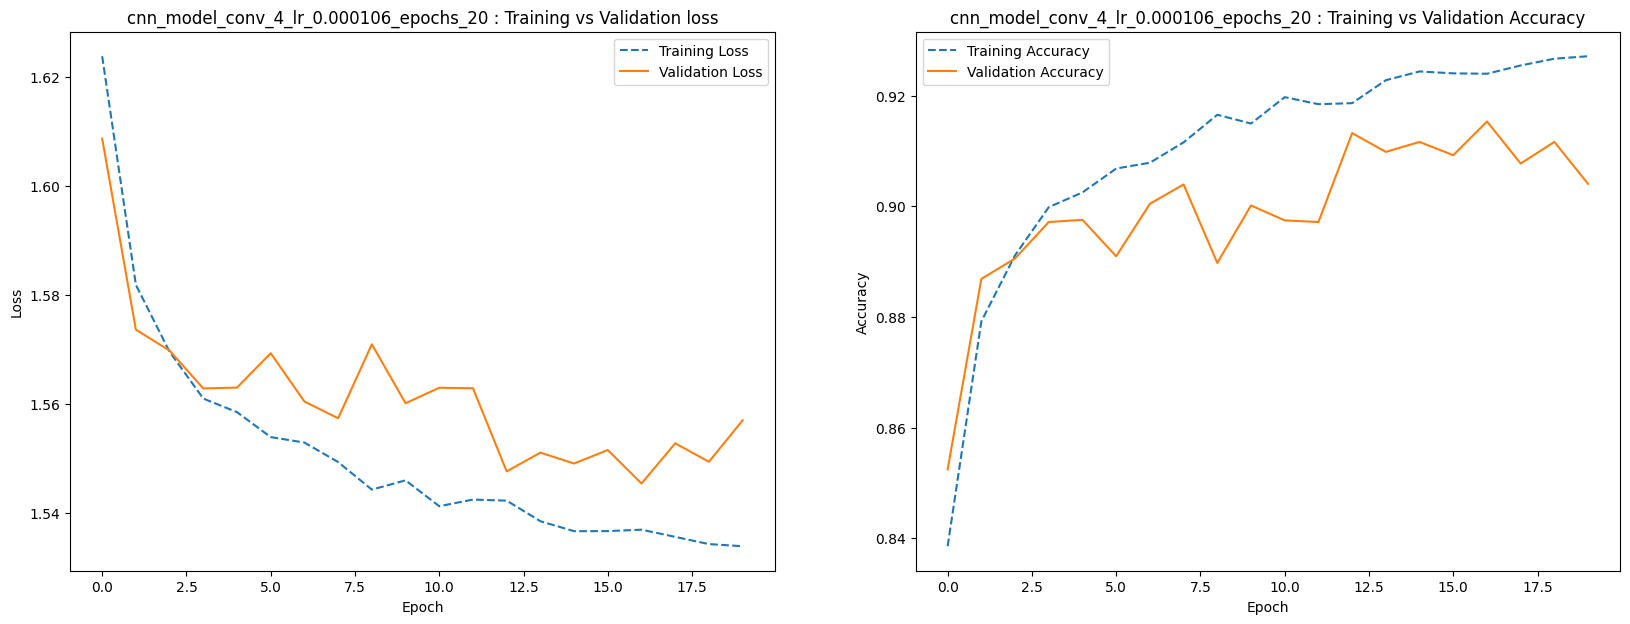


Model Evaluation Summary:


<Figure size 640x480 with 0 Axes>

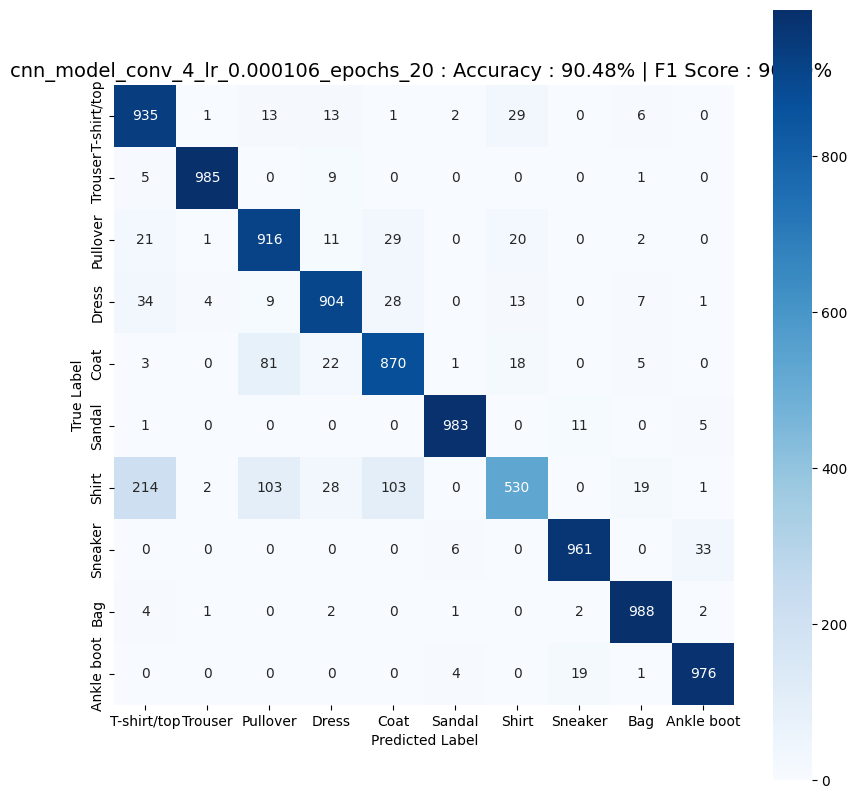

[I 2023-04-23 08:04:20,392] Trial 0 finished with value: 0.9048 and parameters: {'conv_layer': 4, 'lr': 0.0001062517739123608, 'num_epochs': 20}. Best is trial 0 with value: 0.9048.


Accuracy: 90.480%
F1 Score: 90.089%

Classwise Accuracy Score: 
|   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
|         0.935 |     0.985 |      0.916 |   0.904 |   0.87 |    0.983 |    0.53 |     0.961 | 0.988 |        0.976 |

Confusion Matrix:
| True Label   |   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|:-------------|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
| T-shirt/top  |           935 |         1 |         13 |      13 |      1 |        2 |      29 |         0 |     6 |            0 |
| Trouser      |             5 |       985 |          0 |       9 |      0 |        0 |       0 |         0 |     1 |            0 |
| Pullover     |            21 

<Figure size 640x480 with 0 Axes>

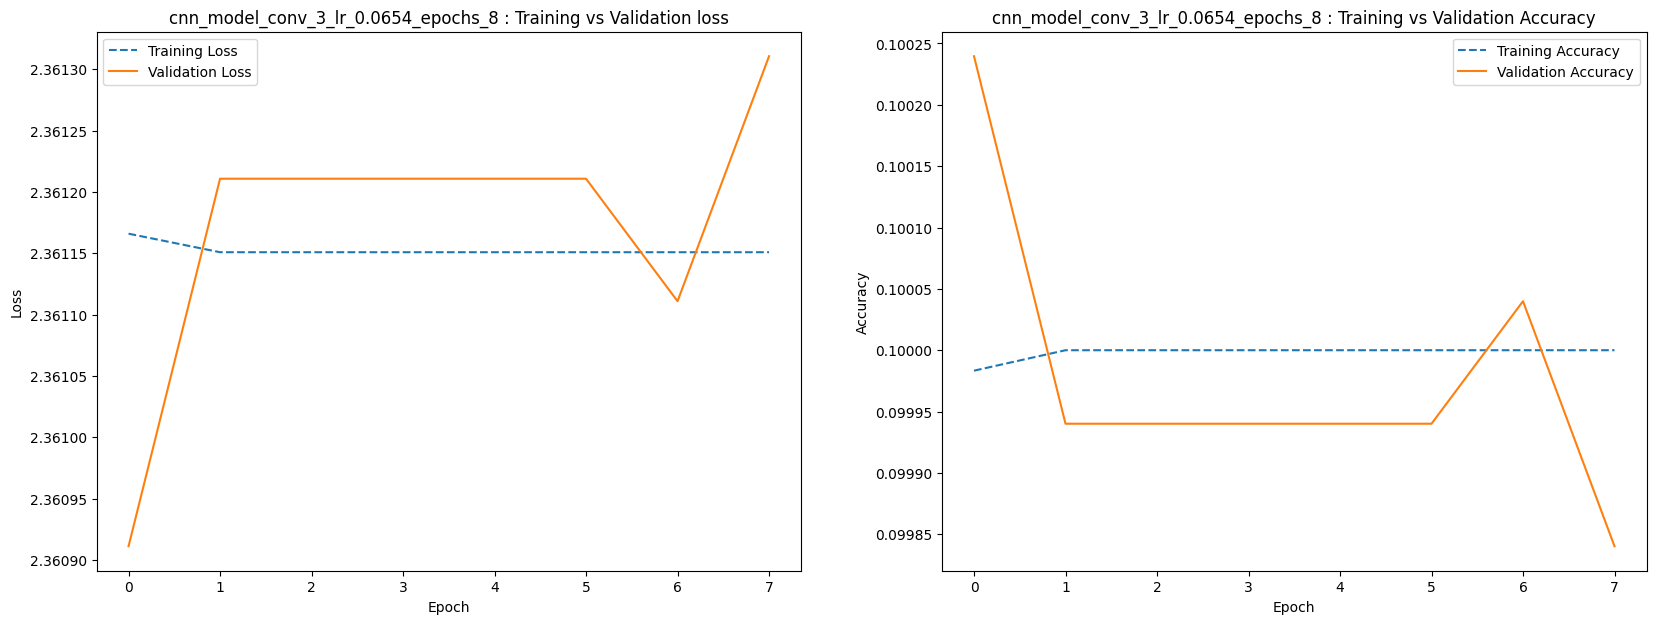


Model Evaluation Summary:


<Figure size 640x480 with 0 Axes>

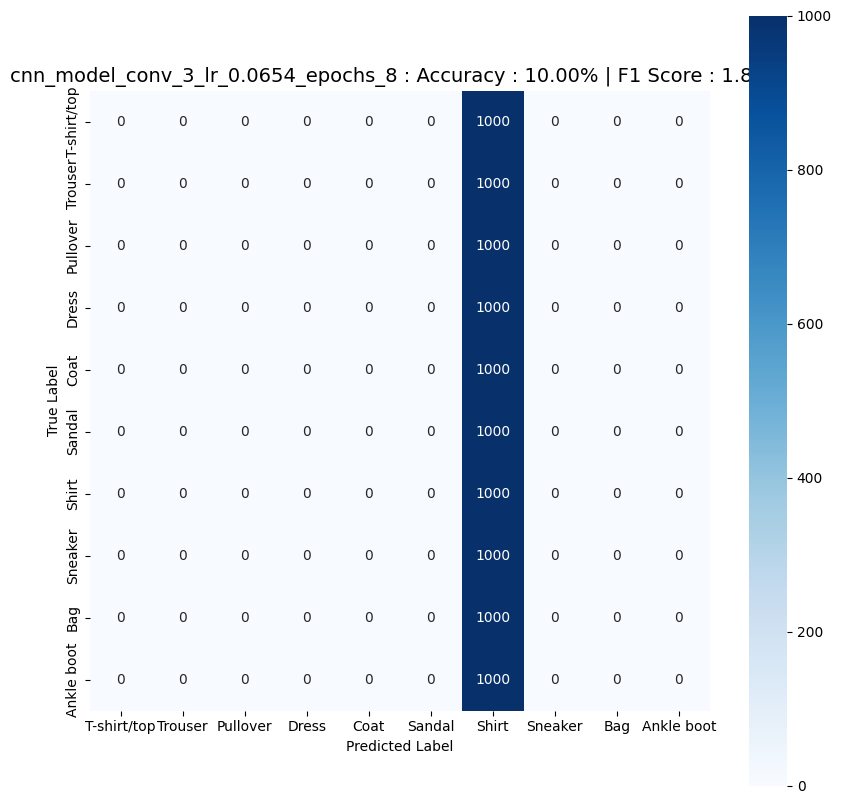

[I 2023-04-23 08:15:04,420] Trial 1 finished with value: 0.1 and parameters: {'conv_layer': 3, 'lr': 0.06538682611540653, 'num_epochs': 8}. Best is trial 0 with value: 0.9048.


Accuracy: 10.000%
F1 Score: 1.818%

Classwise Accuracy Score: 
|   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
|             0 |         0 |          0 |       0 |      0 |        0 |       1 |         0 |     0 |            0 |

Confusion Matrix:
| True Label   |   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|:-------------|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
| T-shirt/top  |             0 |         0 |          0 |       0 |      0 |        0 |    1000 |         0 |     0 |            0 |
| Trouser      |             0 |         0 |          0 |       0 |      0 |        0 |    1000 |         0 |     0 |            0 |
| Pullover     |             0 |

<Figure size 640x480 with 0 Axes>

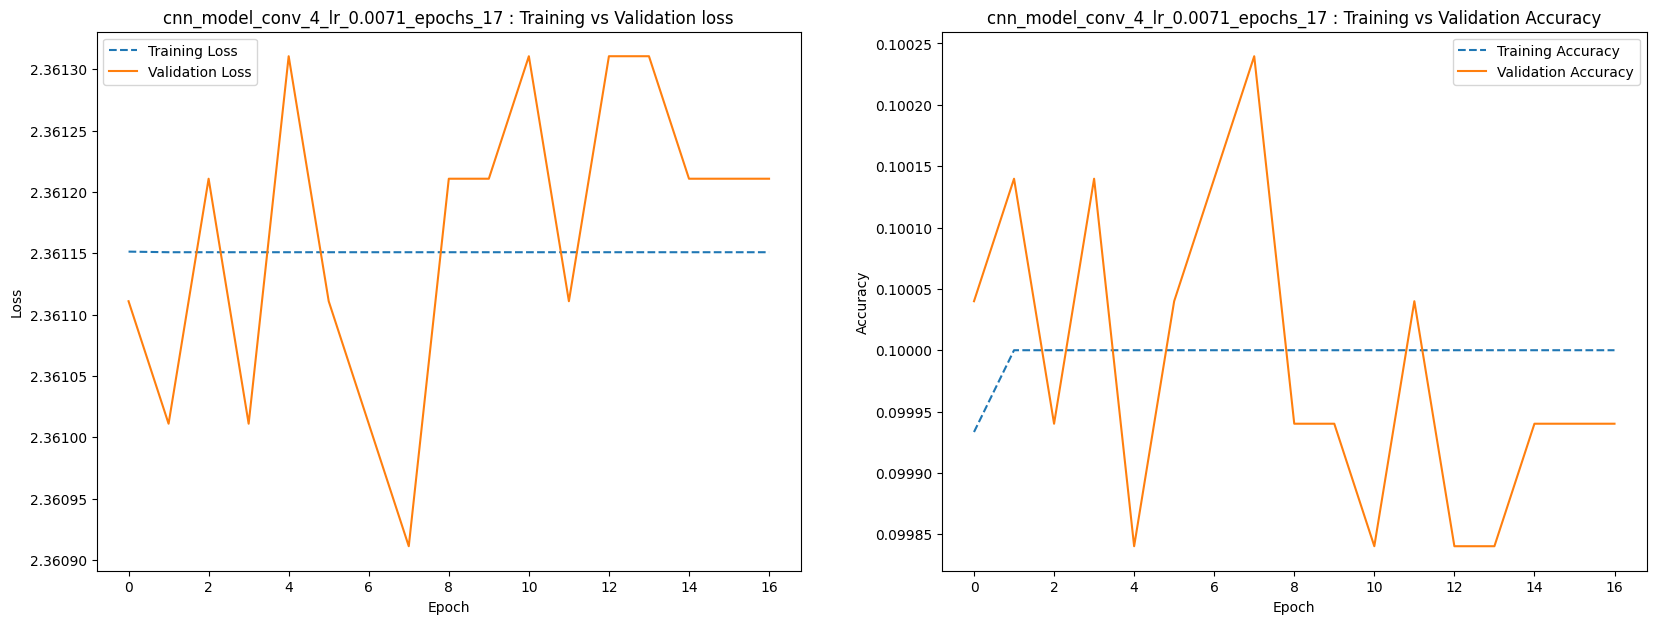


Model Evaluation Summary:


<Figure size 640x480 with 0 Axes>

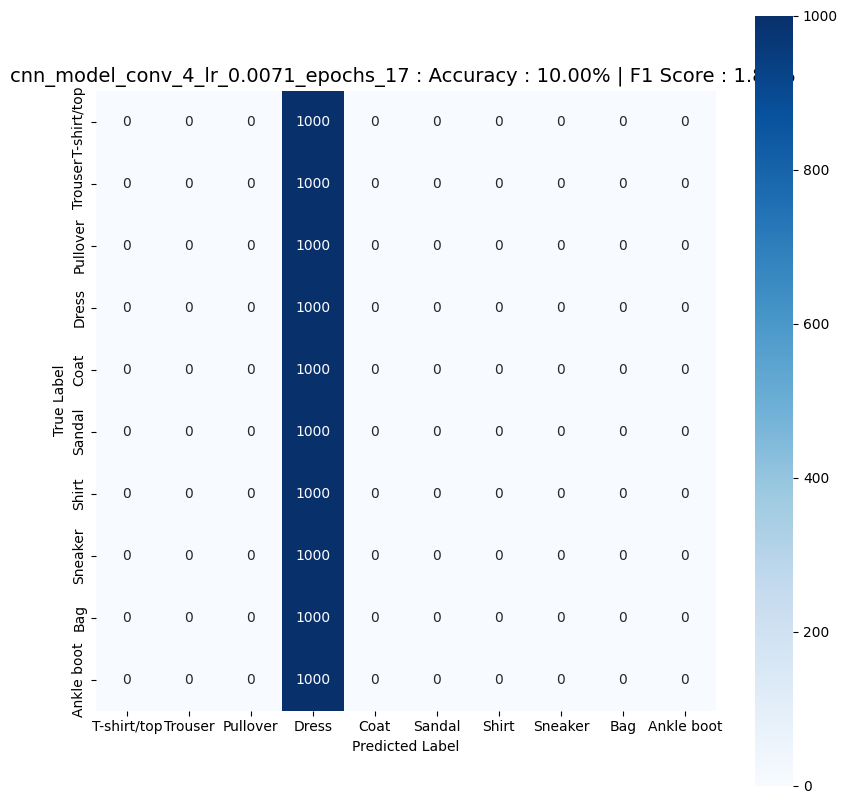

[I 2023-04-23 08:25:37,774] Trial 2 finished with value: 0.1 and parameters: {'conv_layer': 4, 'lr': 0.007096135576129597, 'num_epochs': 17}. Best is trial 0 with value: 0.9048.


Accuracy: 10.000%
F1 Score: 1.818%

Classwise Accuracy Score: 
|   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
|             0 |         0 |          0 |       1 |      0 |        0 |       0 |         0 |     0 |            0 |

Confusion Matrix:
| True Label   |   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|:-------------|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
| T-shirt/top  |             0 |         0 |          0 |    1000 |      0 |        0 |       0 |         0 |     0 |            0 |
| Trouser      |             0 |         0 |          0 |    1000 |      0 |        0 |       0 |         0 |     0 |            0 |
| Pullover     |             0 |

<Figure size 640x480 with 0 Axes>

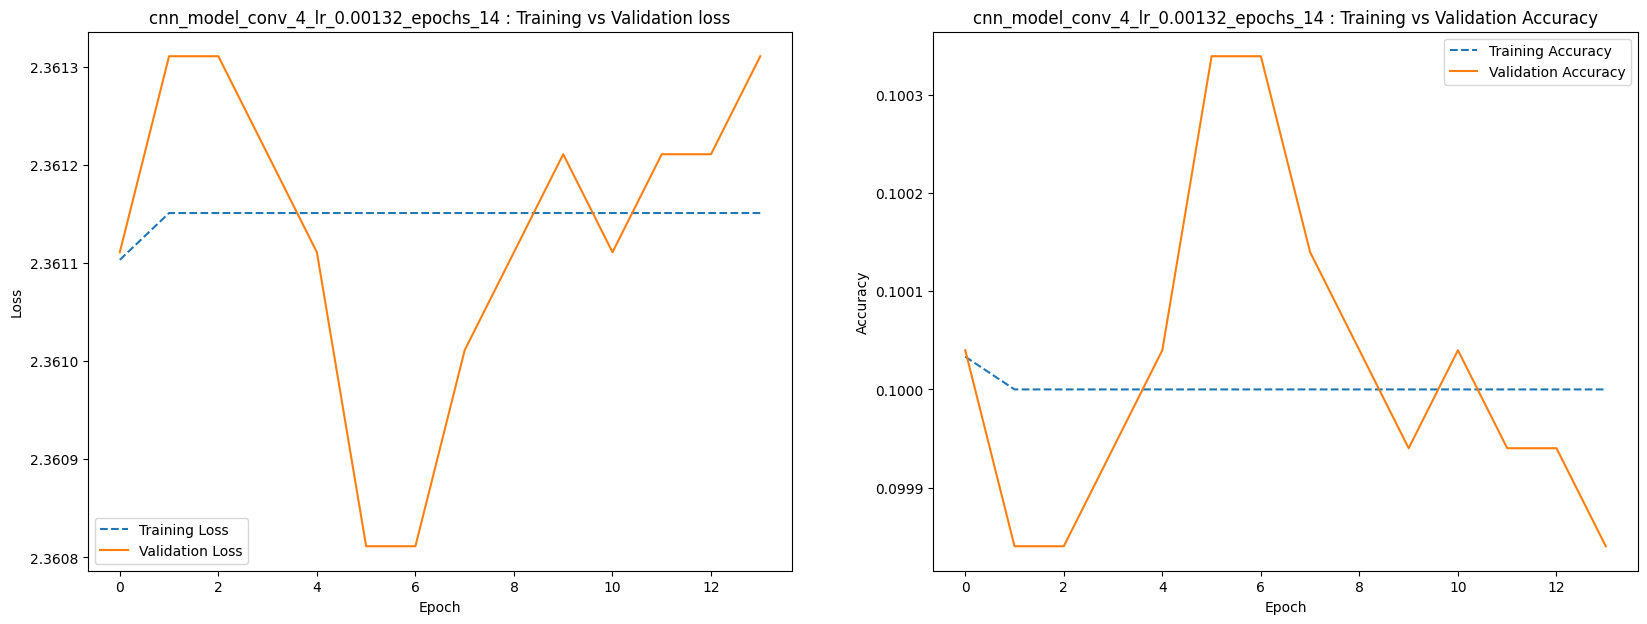


Model Evaluation Summary:


<Figure size 640x480 with 0 Axes>

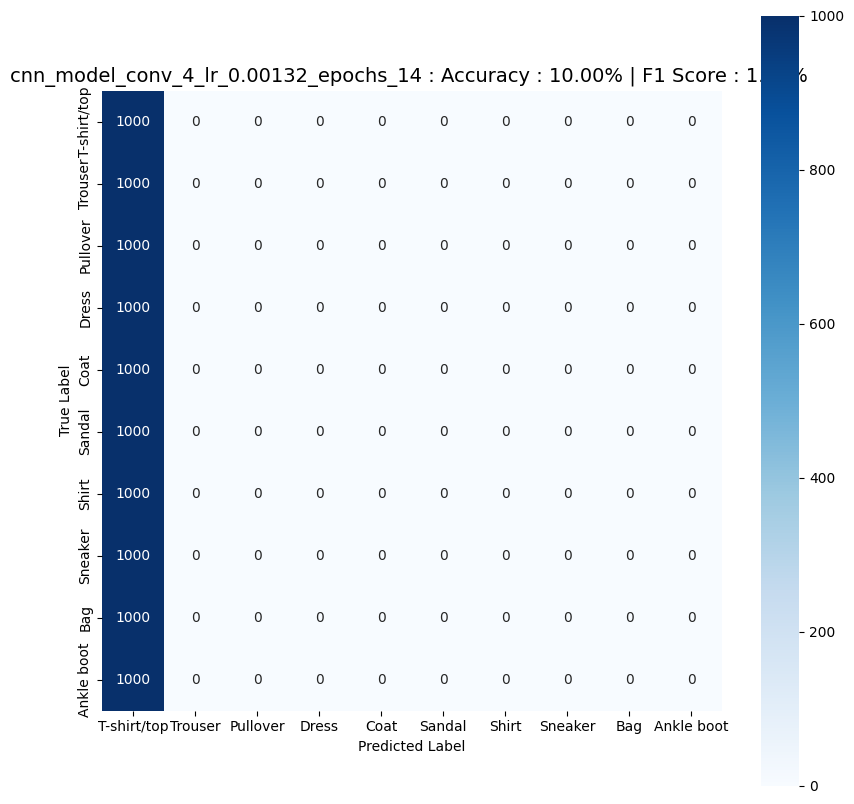

[I 2023-04-23 08:34:23,341] Trial 3 finished with value: 0.1 and parameters: {'conv_layer': 4, 'lr': 0.001322775495092424, 'num_epochs': 14}. Best is trial 0 with value: 0.9048.


Accuracy: 10.000%
F1 Score: 1.818%

Classwise Accuracy Score: 
|   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
|             1 |         0 |          0 |       0 |      0 |        0 |       0 |         0 |     0 |            0 |

Confusion Matrix:
| True Label   |   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|:-------------|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
| T-shirt/top  |          1000 |         0 |          0 |       0 |      0 |        0 |       0 |         0 |     0 |            0 |
| Trouser      |          1000 |         0 |          0 |       0 |      0 |        0 |       0 |         0 |     0 |            0 |
| Pullover     |          1000 |

<Figure size 640x480 with 0 Axes>

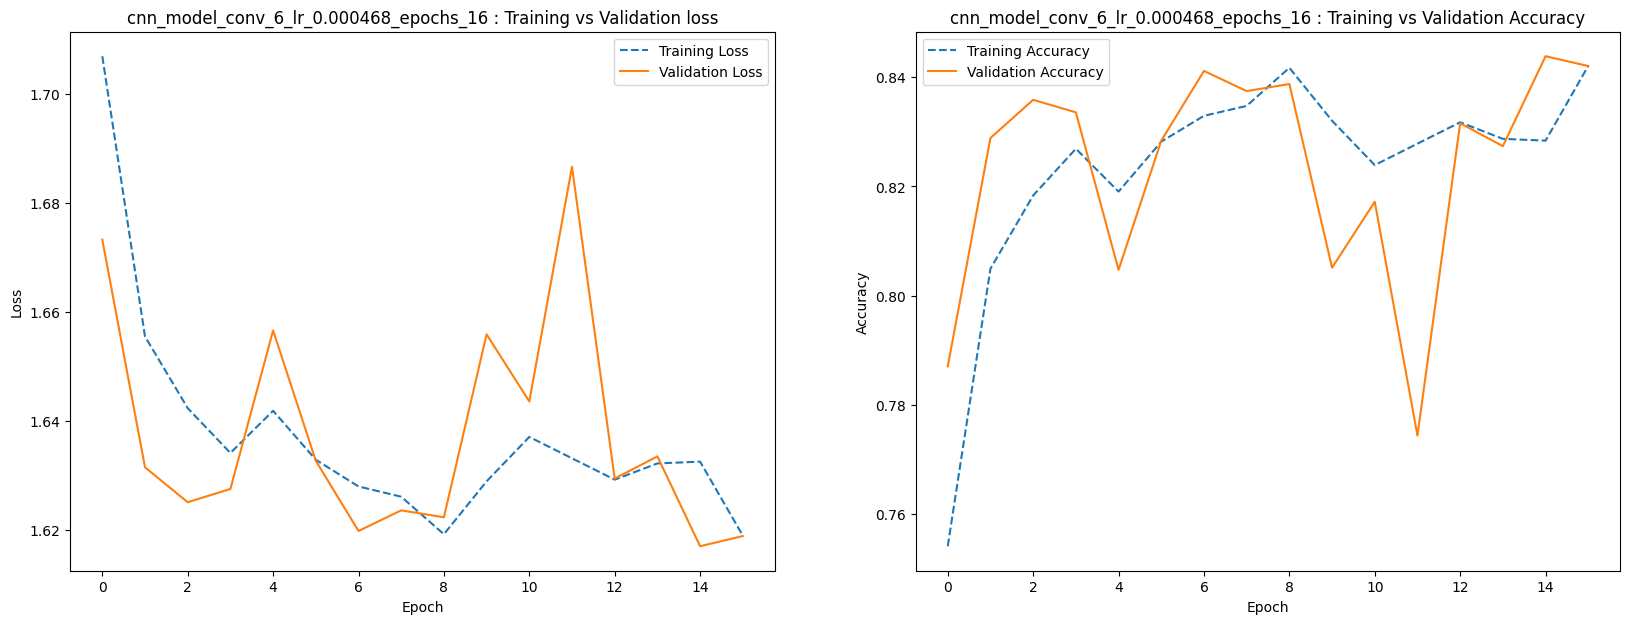


Model Evaluation Summary:


<Figure size 640x480 with 0 Axes>

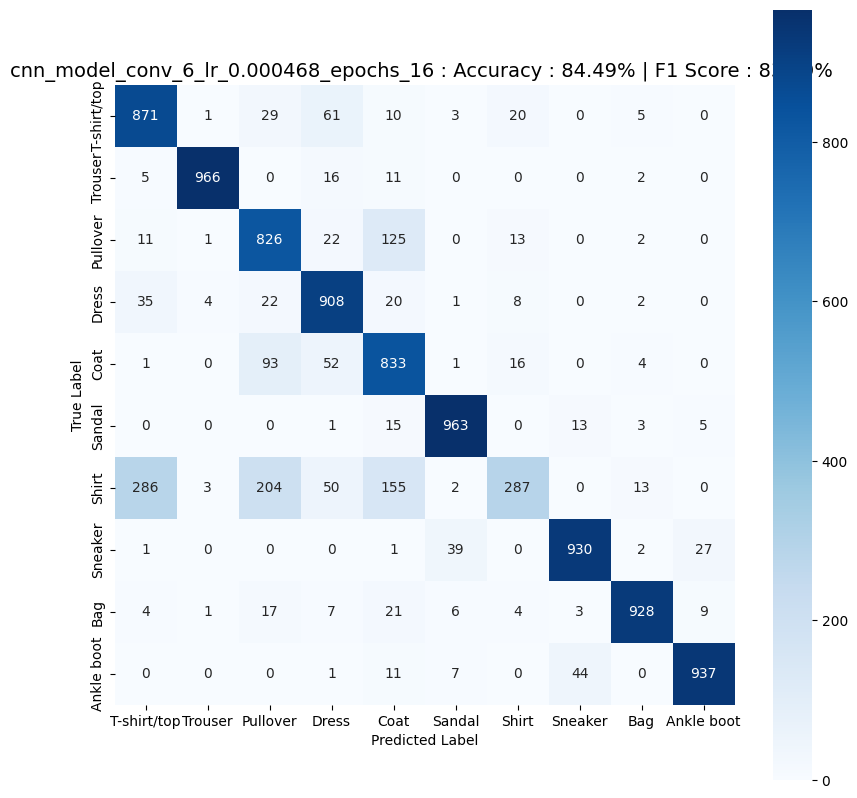

[I 2023-04-23 08:41:35,779] Trial 4 finished with value: 0.8449 and parameters: {'conv_layer': 6, 'lr': 0.00046819291788632807, 'num_epochs': 16}. Best is trial 0 with value: 0.9048.


Accuracy: 84.490%
F1 Score: 83.394%

Classwise Accuracy Score: 
|   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
|         0.871 |     0.966 |      0.826 |   0.908 |  0.833 |    0.963 |   0.287 |      0.93 | 0.928 |        0.937 |

Confusion Matrix:
| True Label   |   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|:-------------|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
| T-shirt/top  |           871 |         1 |         29 |      61 |     10 |        3 |      20 |         0 |     5 |            0 |
| Trouser      |             5 |       966 |          0 |      16 |     11 |        0 |       0 |         0 |     2 |            0 |
| Pullover     |            11 

<Figure size 640x480 with 0 Axes>

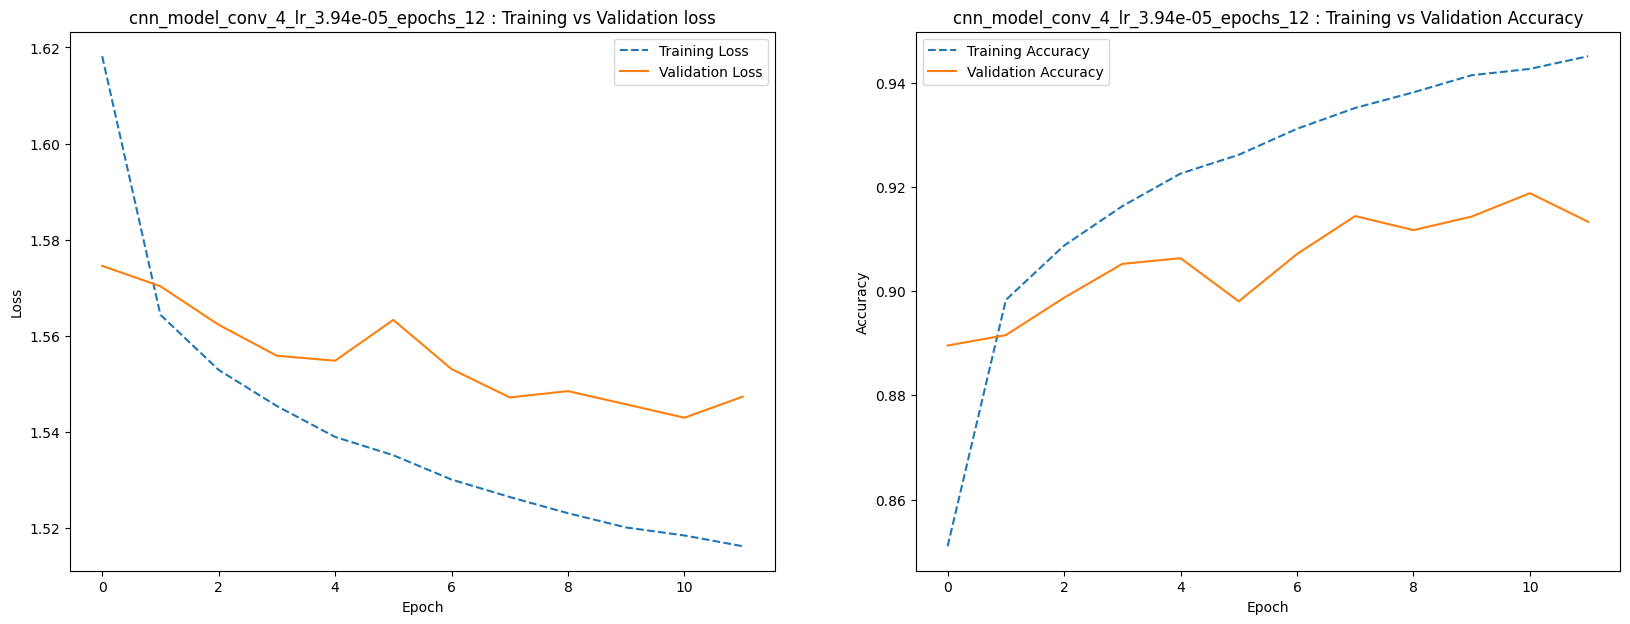


Model Evaluation Summary:


<Figure size 640x480 with 0 Axes>

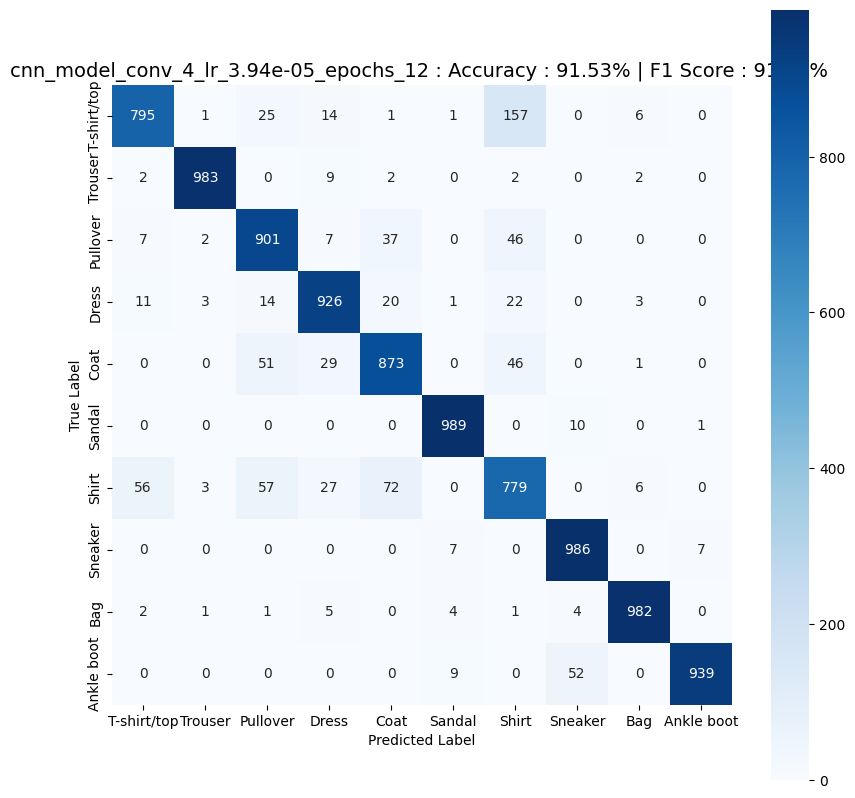

[I 2023-04-23 08:49:16,611] Trial 5 finished with value: 0.9153 and parameters: {'conv_layer': 4, 'lr': 3.9359279093558066e-05, 'num_epochs': 12}. Best is trial 5 with value: 0.9153.


Accuracy: 91.530%
F1 Score: 91.539%

Classwise Accuracy Score: 
|   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
|         0.795 |     0.983 |      0.901 |   0.926 |  0.873 |    0.989 |   0.779 |     0.986 | 0.982 |        0.939 |

Confusion Matrix:
| True Label   |   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|:-------------|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
| T-shirt/top  |           795 |         1 |         25 |      14 |      1 |        1 |     157 |         0 |     6 |            0 |
| Trouser      |             2 |       983 |          0 |       9 |      2 |        0 |       2 |         0 |     2 |            0 |
| Pullover     |             7 

[I 2023-04-23 08:54:58,887] Trial 6 pruned. 


Model ====> cnn_model_conv_3_lr_0.00148_epochs_17
Epoch: 1 (1m 21s) 	Training Loss: 2.361, 	Test Loss: 2.361,  	Training acc: 0.10, 	Test acc: 0.10, 


[I 2023-04-23 08:56:20,520] Trial 7 pruned. 


Model ====> cnn_model_conv_3_lr_0.00121_epochs_9
Epoch: 1 (1m 20s) 	Training Loss: 2.361, 	Test Loss: 2.361,  	Training acc: 0.10, 	Test acc: 0.10, 


[I 2023-04-23 08:57:42,375] Trial 8 pruned. 


Model ====> cnn_model_conv_5_lr_0.0864_epochs_7
Epoch: 1 (0m 28s) 	Training Loss: 2.361, 	Test Loss: 2.361,  	Training acc: 0.10, 	Test acc: 0.10, 


[I 2023-04-23 08:58:10,700] Trial 9 pruned. 


Model ====> cnn_model_conv_6_lr_1.52e-05_epochs_12
Epoch: 1 (0m 28s) 	Training Loss: 1.736, 	Test Loss: 1.641,  	Training acc: 0.77, 	Test acc: 0.83, 
Epoch: 2 (0m 27s) 	Training Loss: 1.627, 	Test Loss: 1.628,  	Training acc: 0.84, 	Test acc: 0.83, 
Epoch: 3 (0m 27s) 	Training Loss: 1.615, 	Test Loss: 1.617,  	Training acc: 0.85, 	Test acc: 0.85, 
Epoch: 4 (0m 27s) 	Training Loss: 1.581, 	Test Loss: 1.585,  	Training acc: 0.89, 	Test acc: 0.88, 
Epoch: 5 (0m 28s) 	Training Loss: 1.561, 	Test Loss: 1.578,  	Training acc: 0.90, 	Test acc: 0.89, 
Epoch: 6 (0m 27s) 	Training Loss: 1.552, 	Test Loss: 1.572,  	Training acc: 0.91, 	Test acc: 0.89, 
Epoch: 7 (0m 27s) 	Training Loss: 1.545, 	Test Loss: 1.569,  	Training acc: 0.92, 	Test acc: 0.89, 
Epoch: 8 (0m 27s) 	Training Loss: 1.540, 	Test Loss: 1.565,  	Training acc: 0.92, 	Test acc: 0.90, 
Epoch: 9 (0m 27s) 	Training Loss: 1.535, 	Test Loss: 1.563,  	Training acc: 0.93, 	Test acc: 0.90, 
Epoch: 10 (0m 28s) 	Training Loss: 1.532, 	Test L

<Figure size 640x480 with 0 Axes>

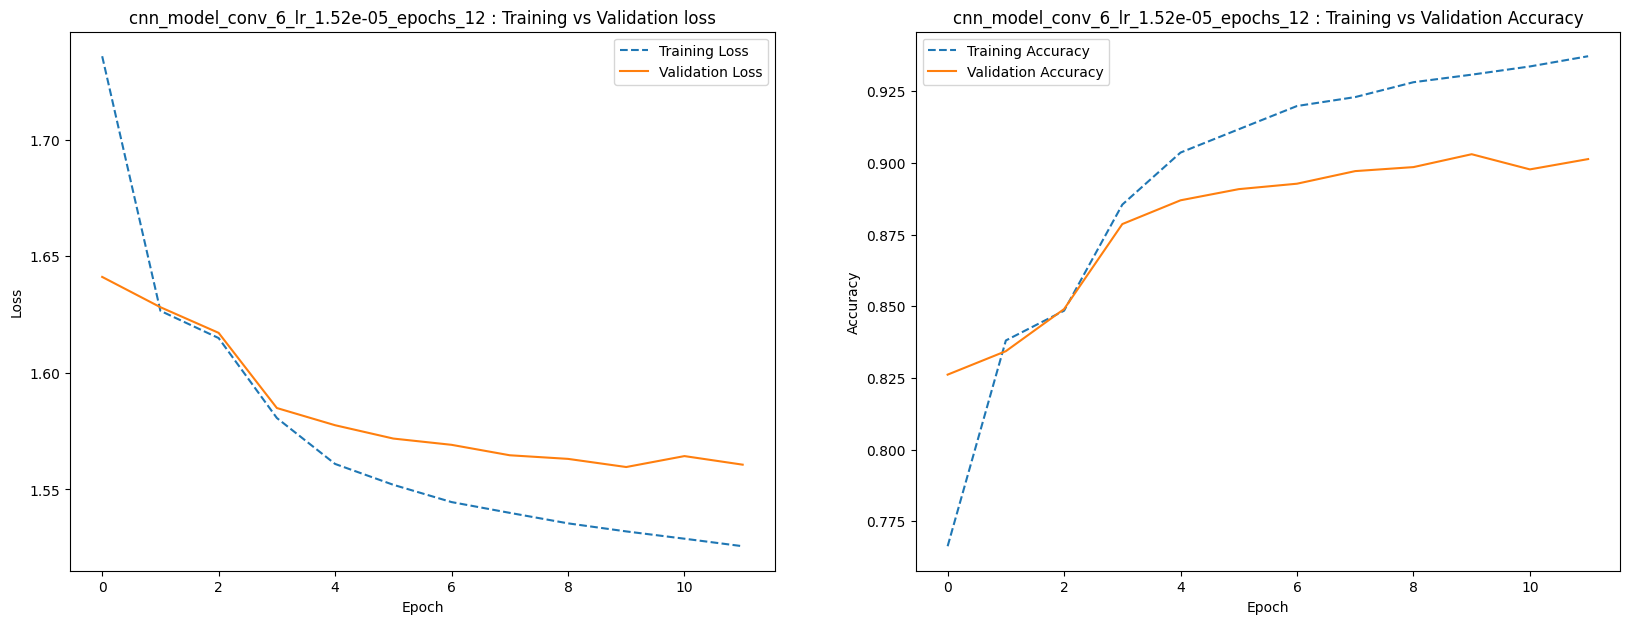


Model Evaluation Summary:


<Figure size 640x480 with 0 Axes>

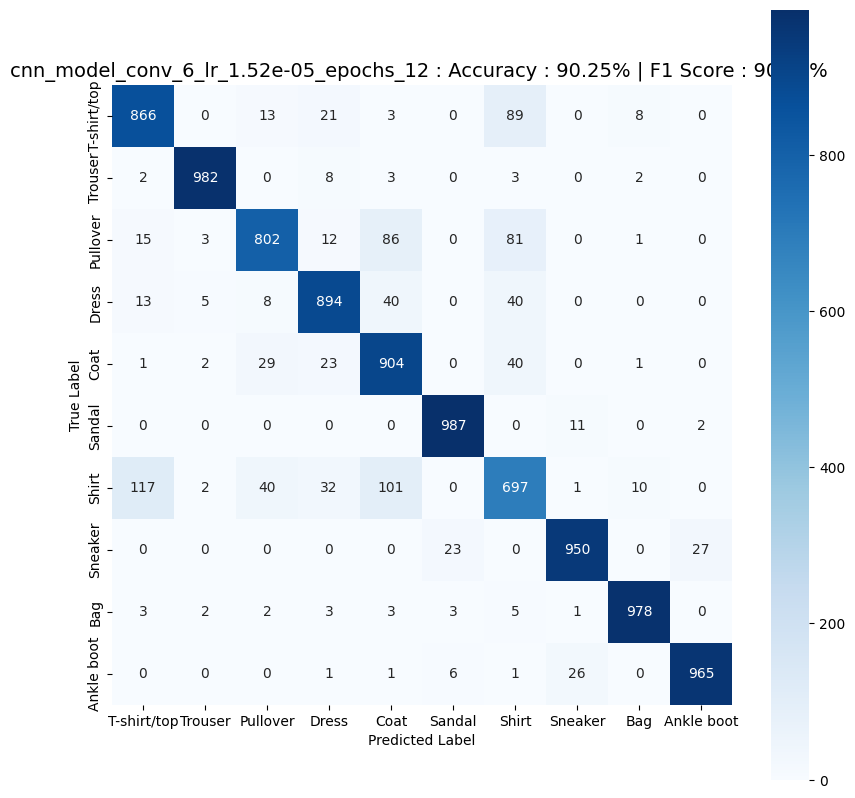

[I 2023-04-23 09:03:46,094] Trial 10 finished with value: 0.9025 and parameters: {'conv_layer': 6, 'lr': 1.517480520857079e-05, 'num_epochs': 12}. Best is trial 5 with value: 0.9153.


Accuracy: 90.250%
F1 Score: 90.223%

Classwise Accuracy Score: 
|   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
|         0.866 |     0.982 |      0.802 |   0.894 |  0.904 |    0.987 |   0.697 |      0.95 | 0.978 |        0.965 |

Confusion Matrix:
| True Label   |   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|:-------------|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
| T-shirt/top  |           866 |         0 |         13 |      21 |      3 |        0 |      89 |         0 |     8 |            0 |
| Trouser      |             2 |       982 |          0 |       8 |      3 |        0 |       3 |         0 |     2 |            0 |
| Pullover     |            15 

<Figure size 640x480 with 0 Axes>

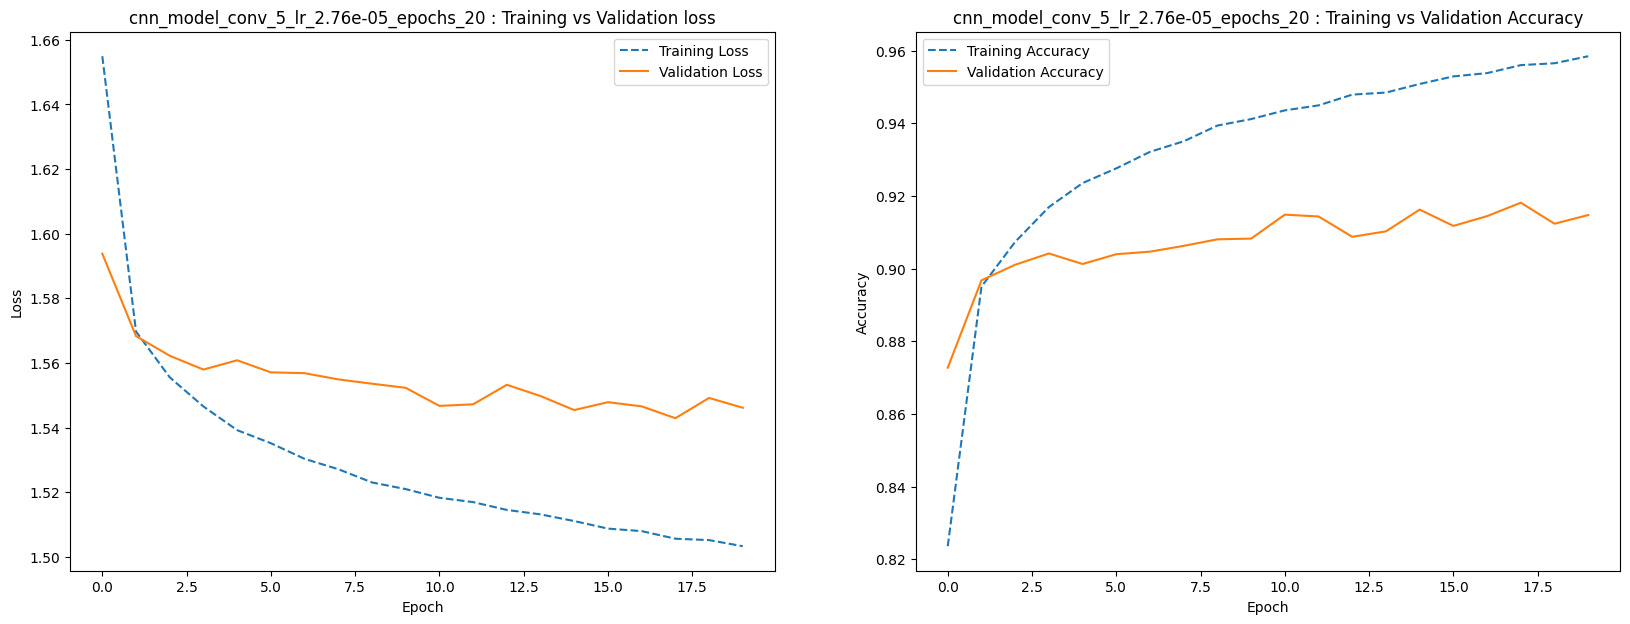


Model Evaluation Summary:


<Figure size 640x480 with 0 Axes>

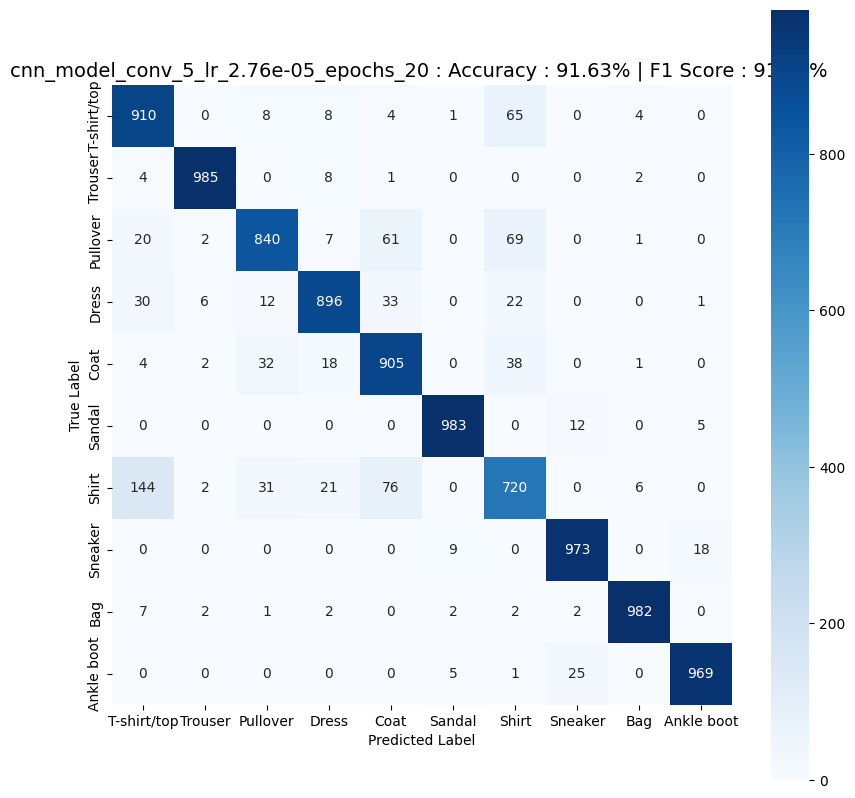

[I 2023-04-23 09:13:18,330] Trial 11 finished with value: 0.9163 and parameters: {'conv_layer': 5, 'lr': 2.7604241453878964e-05, 'num_epochs': 20}. Best is trial 11 with value: 0.9163.


Accuracy: 91.630%
F1 Score: 91.598%

Classwise Accuracy Score: 
|   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
|          0.91 |     0.985 |       0.84 |   0.896 |  0.905 |    0.983 |    0.72 |     0.973 | 0.982 |        0.969 |

Confusion Matrix:
| True Label   |   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|:-------------|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
| T-shirt/top  |           910 |         0 |          8 |       8 |      4 |        1 |      65 |         0 |     4 |            0 |
| Trouser      |             4 |       985 |          0 |       8 |      1 |        0 |       0 |         0 |     2 |            0 |
| Pullover     |            20 

<Figure size 640x480 with 0 Axes>

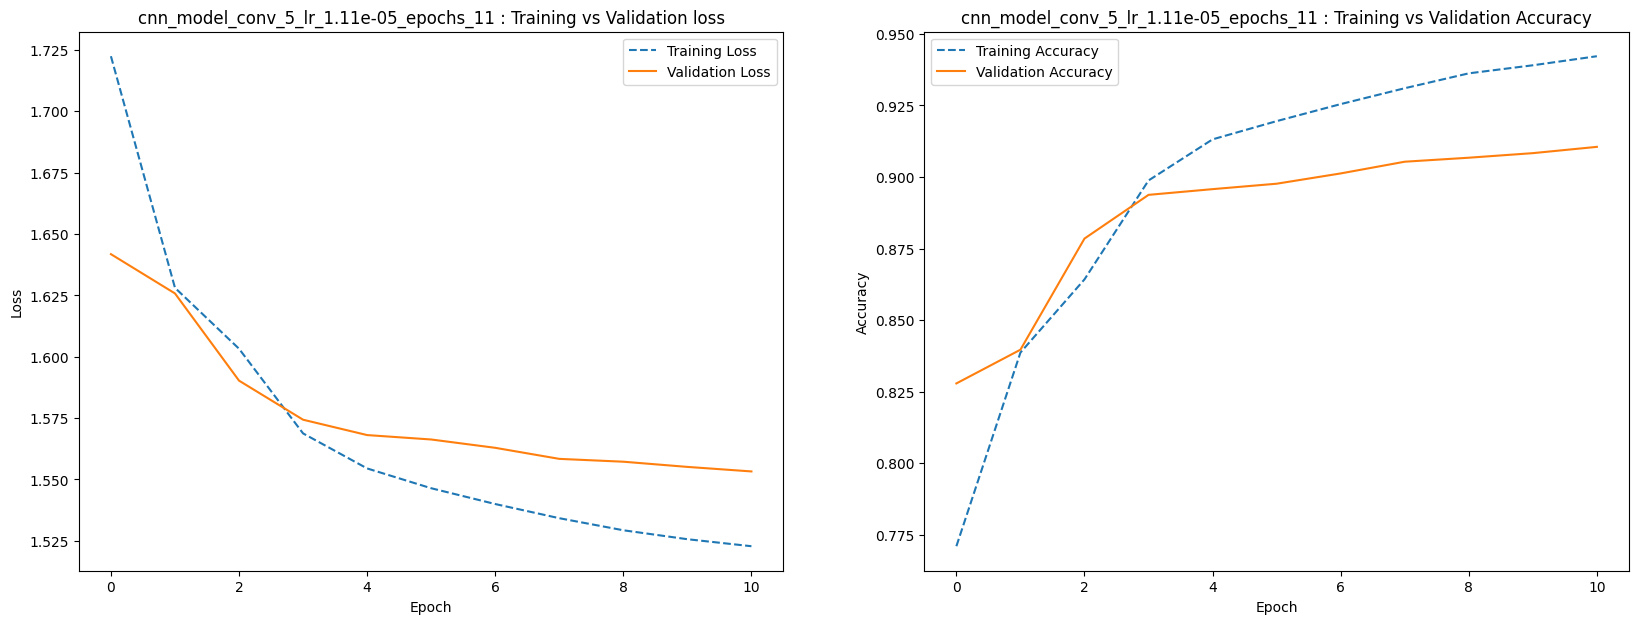


Model Evaluation Summary:


<Figure size 640x480 with 0 Axes>

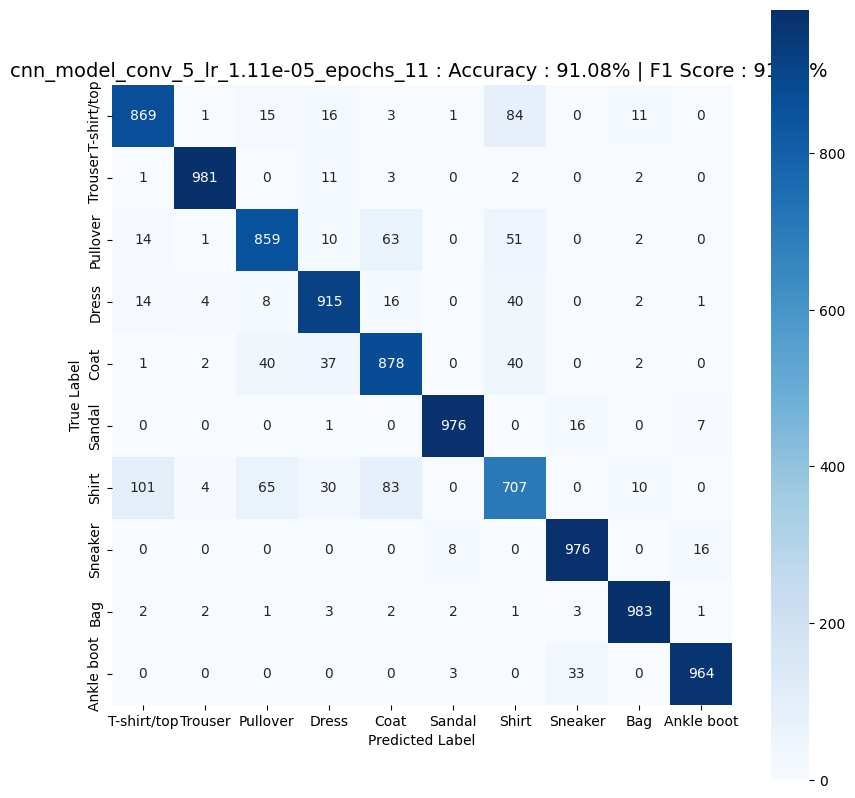

[I 2023-04-23 09:18:33,693] Trial 12 finished with value: 0.9108 and parameters: {'conv_layer': 5, 'lr': 1.1090309915069679e-05, 'num_epochs': 11}. Best is trial 11 with value: 0.9163.


Accuracy: 91.080%
F1 Score: 91.022%

Classwise Accuracy Score: 
|   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
|         0.869 |     0.981 |      0.859 |   0.915 |  0.878 |    0.976 |   0.707 |     0.976 | 0.983 |        0.964 |

Confusion Matrix:
| True Label   |   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|:-------------|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
| T-shirt/top  |           869 |         1 |         15 |      16 |      3 |        1 |      84 |         0 |    11 |            0 |
| Trouser      |             1 |       981 |          0 |      11 |      3 |        0 |       2 |         0 |     2 |            0 |
| Pullover     |            14 

<Figure size 640x480 with 0 Axes>

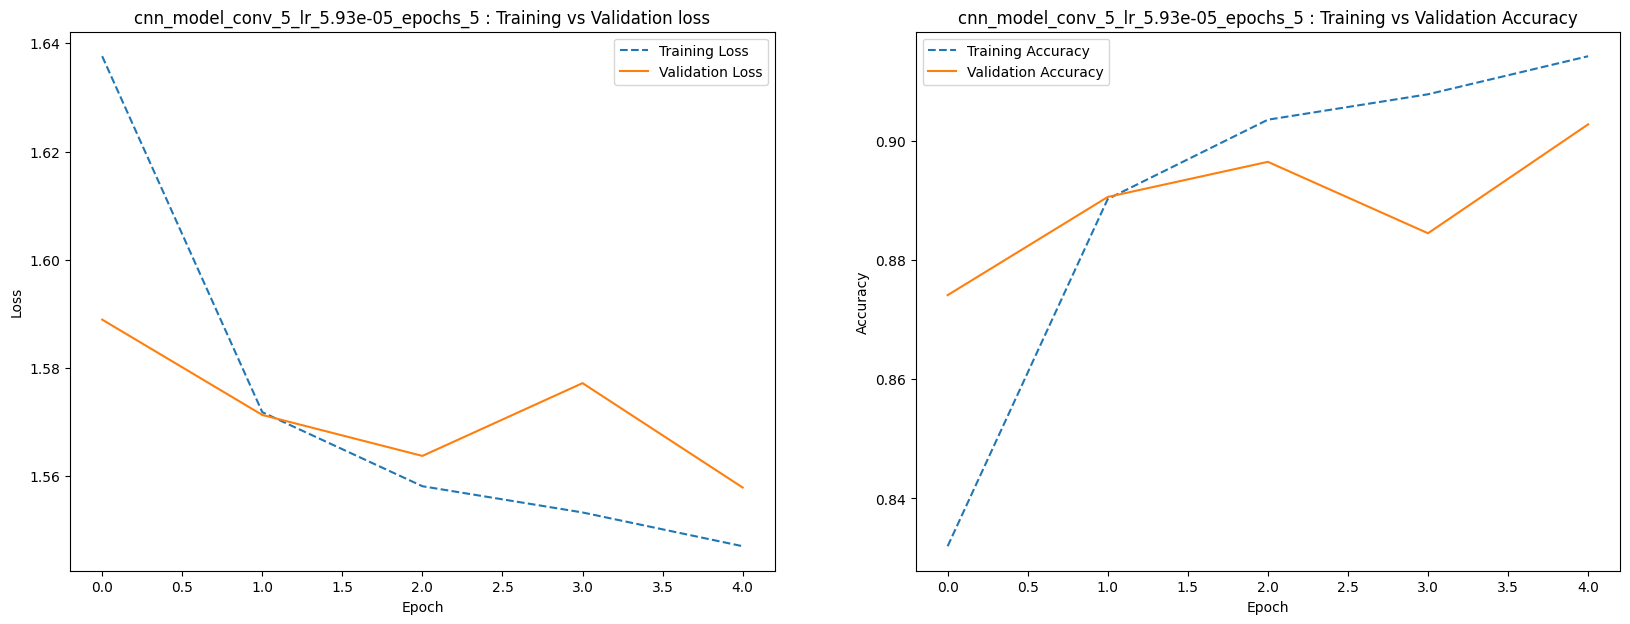


Model Evaluation Summary:


<Figure size 640x480 with 0 Axes>

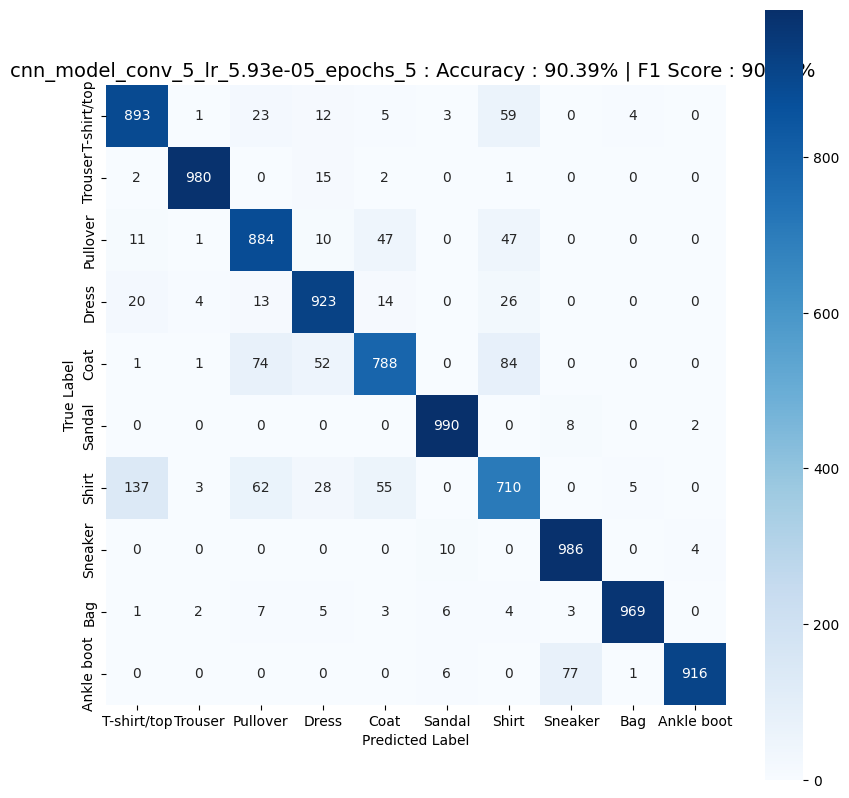

[I 2023-04-23 09:21:03,173] Trial 13 finished with value: 0.9039 and parameters: {'conv_layer': 5, 'lr': 5.927211099158287e-05, 'num_epochs': 5}. Best is trial 11 with value: 0.9163.


Accuracy: 90.390%
F1 Score: 90.332%

Classwise Accuracy Score: 
|   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
|         0.893 |      0.98 |      0.884 |   0.923 |  0.788 |     0.99 |    0.71 |     0.986 | 0.969 |        0.916 |

Confusion Matrix:
| True Label   |   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|:-------------|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
| T-shirt/top  |           893 |         1 |         23 |      12 |      5 |        3 |      59 |         0 |     4 |            0 |
| Trouser      |             2 |       980 |          0 |      15 |      2 |        0 |       1 |         0 |     0 |            0 |
| Pullover     |            11 

[I 2023-04-23 09:29:11,685] Trial 14 pruned. 


Model ====> cnn_model_conv_5_lr_0.000155_epochs_14
Epoch: 1 (0m 28s) 	Training Loss: 1.651, 	Test Loss: 1.618,  	Training acc: 0.81, 	Test acc: 0.84, 
Epoch: 2 (0m 28s) 	Training Loss: 1.592, 	Test Loss: 1.593,  	Training acc: 0.87, 	Test acc: 0.87, 
Epoch: 3 (0m 27s) 	Training Loss: 1.579, 	Test Loss: 1.588,  	Training acc: 0.88, 	Test acc: 0.87, 
Epoch: 4 (0m 27s) 	Training Loss: 1.569, 	Test Loss: 1.564,  	Training acc: 0.89, 	Test acc: 0.90, 
Epoch: 5 (0m 28s) 	Training Loss: 1.564, 	Test Loss: 1.569,  	Training acc: 0.90, 	Test acc: 0.89, 
Epoch: 6 (0m 27s) 	Training Loss: 1.561, 	Test Loss: 1.563,  	Training acc: 0.90, 	Test acc: 0.90, 
Epoch: 7 (0m 28s) 	Training Loss: 1.558, 	Test Loss: 1.562,  	Training acc: 0.90, 	Test acc: 0.90, 
Epoch: 8 (0m 27s) 	Training Loss: 1.553, 	Test Loss: 1.562,  	Training acc: 0.91, 	Test acc: 0.90, 
Epoch: 9 (0m 28s) 	Training Loss: 1.555, 	Test Loss: 1.561,  	Training acc: 0.91, 	Test acc: 0.90, 
Epoch: 10 (0m 27s) 	Training Loss: 1.551, 	Test L

[I 2023-04-23 09:33:51,644] Trial 15 pruned. 


Model ====> cnn_model_conv_6_lr_2.23e-05_epochs_10
Epoch: 1 (0m 26s) 	Training Loss: 1.707, 	Test Loss: 1.632,  	Training acc: 0.78, 	Test acc: 0.83, 
Epoch: 2 (0m 26s) 	Training Loss: 1.593, 	Test Loss: 1.589,  	Training acc: 0.87, 	Test acc: 0.88, 
Epoch: 3 (0m 26s) 	Training Loss: 1.569, 	Test Loss: 1.573,  	Training acc: 0.90, 	Test acc: 0.89, 
Epoch: 4 (0m 26s) 	Training Loss: 1.557, 	Test Loss: 1.567,  	Training acc: 0.91, 	Test acc: 0.90, 
Epoch: 5 (0m 26s) 	Training Loss: 1.550, 	Test Loss: 1.568,  	Training acc: 0.91, 	Test acc: 0.89, 
Epoch: 6 (0m 26s) 	Training Loss: 1.545, 	Test Loss: 1.563,  	Training acc: 0.92, 	Test acc: 0.90, 
Epoch: 7 (0m 26s) 	Training Loss: 1.540, 	Test Loss: 1.561,  	Training acc: 0.92, 	Test acc: 0.90, 
Epoch: 8 (0m 26s) 	Training Loss: 1.536, 	Test Loss: 1.559,  	Training acc: 0.93, 	Test acc: 0.90, 
Epoch: 9 (0m 26s) 	Training Loss: 1.533, 	Test Loss: 1.558,  	Training acc: 0.93, 	Test acc: 0.90, 
Epoch: 10 (0m 26s) 	Training Loss: 1.530, 	Test L

<Figure size 640x480 with 0 Axes>

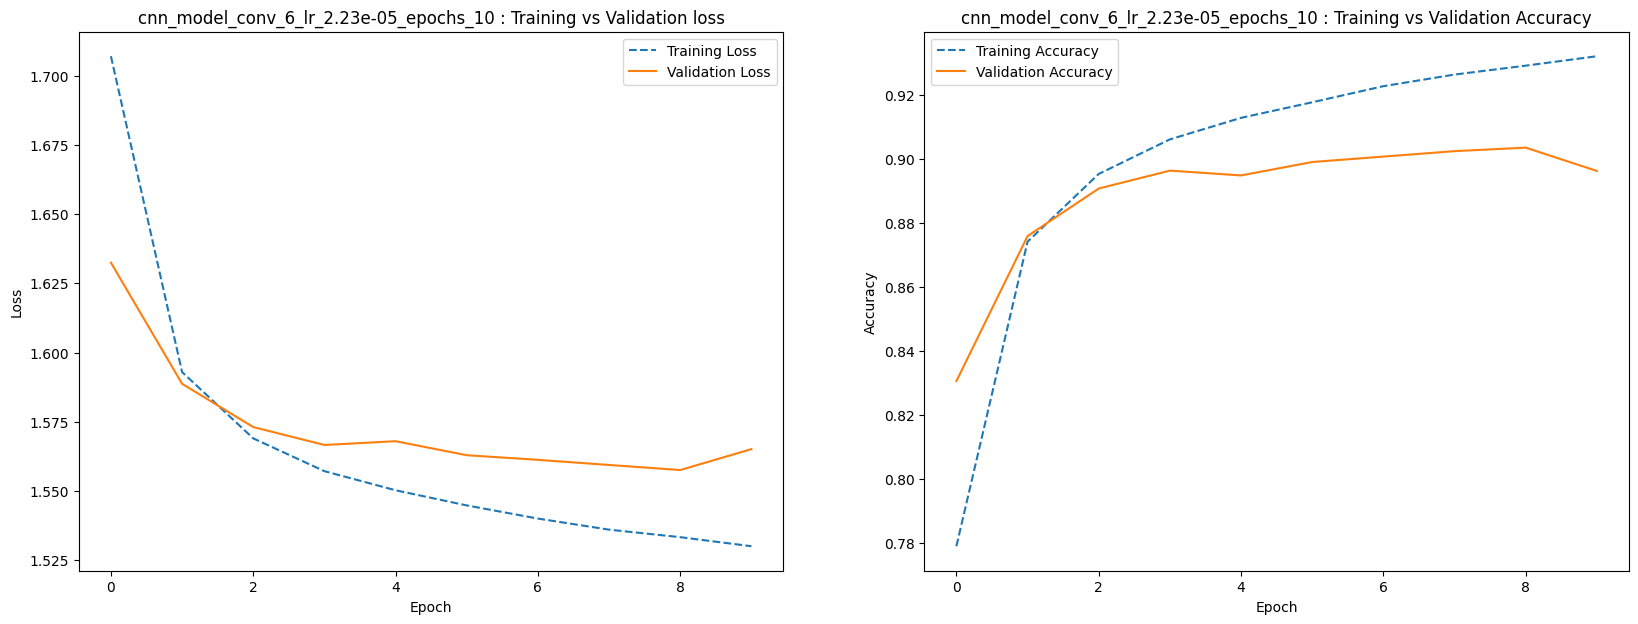


Model Evaluation Summary:


<Figure size 640x480 with 0 Axes>

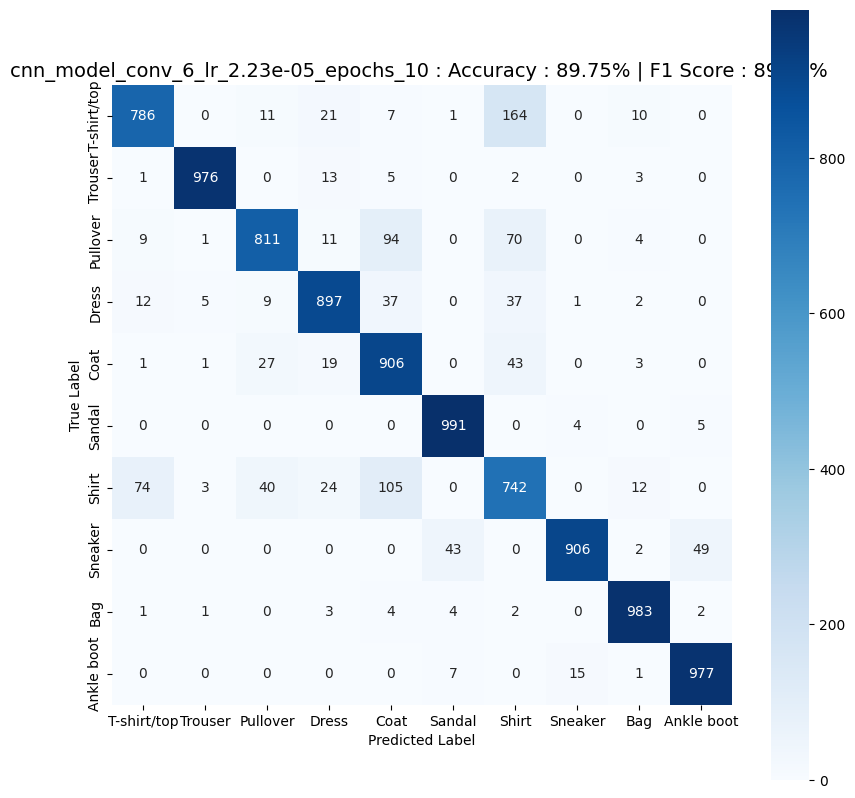

[I 2023-04-23 09:38:21,368] Trial 16 finished with value: 0.8975 and parameters: {'conv_layer': 6, 'lr': 2.2291123420958997e-05, 'num_epochs': 10}. Best is trial 11 with value: 0.9163.


Accuracy: 89.750%
F1 Score: 89.778%

Classwise Accuracy Score: 
|   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
|         0.786 |     0.976 |      0.811 |   0.897 |  0.906 |    0.991 |   0.742 |     0.906 | 0.983 |        0.977 |

Confusion Matrix:
| True Label   |   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|:-------------|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
| T-shirt/top  |           786 |         0 |         11 |      21 |      7 |        1 |     164 |         0 |    10 |            0 |
| Trouser      |             1 |       976 |          0 |      13 |      5 |        0 |       2 |         0 |     3 |            0 |
| Pullover     |             9 

<Figure size 640x480 with 0 Axes>

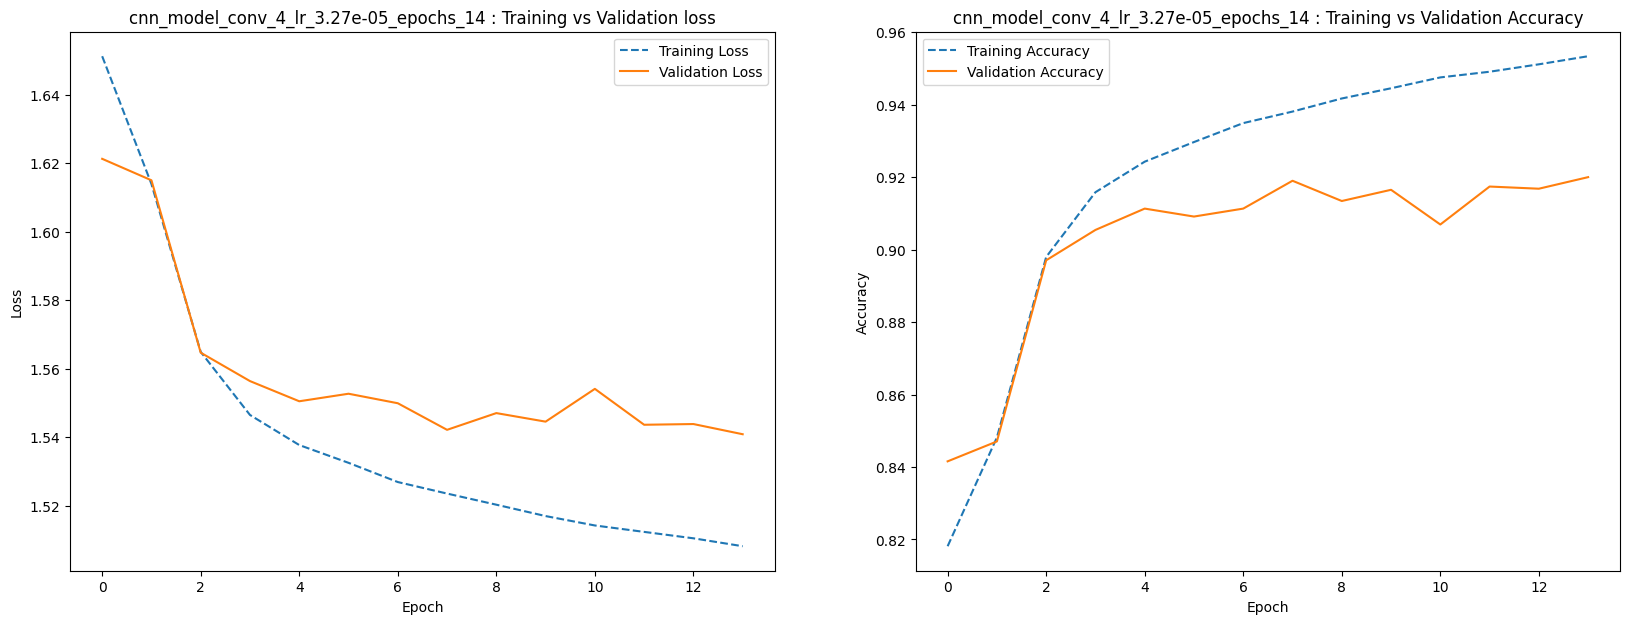


Model Evaluation Summary:


<Figure size 640x480 with 0 Axes>

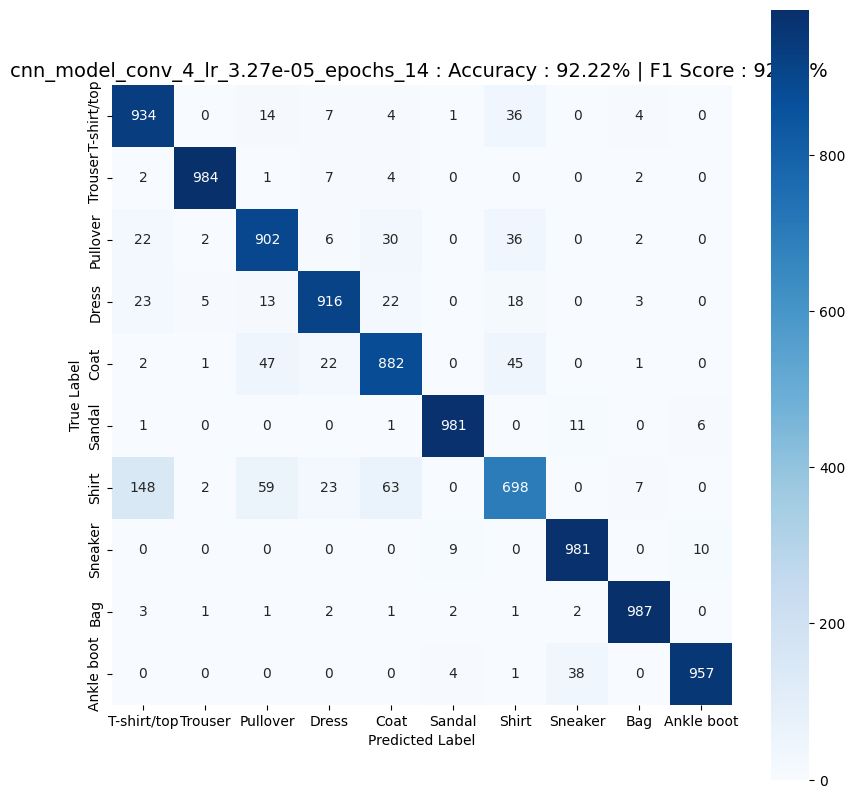

[I 2023-04-23 09:47:13,839] Trial 17 finished with value: 0.9222 and parameters: {'conv_layer': 4, 'lr': 3.267792362723155e-05, 'num_epochs': 14}. Best is trial 17 with value: 0.9222.


Accuracy: 92.220%
F1 Score: 92.127%

Classwise Accuracy Score: 
|   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
|         0.934 |     0.984 |      0.902 |   0.916 |  0.882 |    0.981 |   0.698 |     0.981 | 0.987 |        0.957 |

Confusion Matrix:
| True Label   |   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|:-------------|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
| T-shirt/top  |           934 |         0 |         14 |       7 |      4 |        1 |      36 |         0 |     4 |            0 |
| Trouser      |             2 |       984 |          1 |       7 |      4 |        0 |       0 |         0 |     2 |            0 |
| Pullover     |            22 

[I 2023-04-23 09:48:37,763] Trial 18 pruned. 


Model ====> cnn_model_conv_4_lr_2.11e-05_epochs_14
Epoch: 1 (0m 37s) 	Training Loss: 1.657, 	Test Loss: 1.625,  	Training acc: 0.82, 	Test acc: 0.84, 
Epoch: 2 (0m 37s) 	Training Loss: 1.613, 	Test Loss: 1.616,  	Training acc: 0.85, 	Test acc: 0.85, 
Epoch: 3 (0m 37s) 	Training Loss: 1.605, 	Test Loss: 1.609,  	Training acc: 0.86, 	Test acc: 0.85, 


[I 2023-04-23 09:50:29,987] Trial 19 pruned. 


Model ====> cnn_model_conv_3_lr_1e-05_epochs_19
Epoch: 1 (1m 19s) 	Training Loss: 1.625, 	Test Loss: 1.588,  	Training acc: 0.85, 	Test acc: 0.88, 
Epoch: 2 (1m 20s) 	Training Loss: 1.564, 	Test Loss: 1.571,  	Training acc: 0.90, 	Test acc: 0.89, 
Epoch: 3 (1m 19s) 	Training Loss: 1.550, 	Test Loss: 1.561,  	Training acc: 0.91, 	Test acc: 0.90, 
Epoch: 4 (1m 20s) 	Training Loss: 1.540, 	Test Loss: 1.562,  	Training acc: 0.92, 	Test acc: 0.90, 
Epoch: 5 (1m 19s) 	Training Loss: 1.531, 	Test Loss: 1.558,  	Training acc: 0.93, 	Test acc: 0.91, 
Epoch: 6 (1m 19s) 	Training Loss: 1.526, 	Test Loss: 1.558,  	Training acc: 0.94, 	Test acc: 0.90, 
Epoch: 7 (1m 19s) 	Training Loss: 1.520, 	Test Loss: 1.549,  	Training acc: 0.94, 	Test acc: 0.91, 
Epoch: 8 (1m 19s) 	Training Loss: 1.516, 	Test Loss: 1.550,  	Training acc: 0.95, 	Test acc: 0.91, 
Epoch: 9 (1m 19s) 	Training Loss: 1.511, 	Test Loss: 1.550,  	Training acc: 0.95, 	Test acc: 0.91, 
Epoch: 10 (1m 19s) 	Training Loss: 1.508, 	Test Loss

<Figure size 640x480 with 0 Axes>

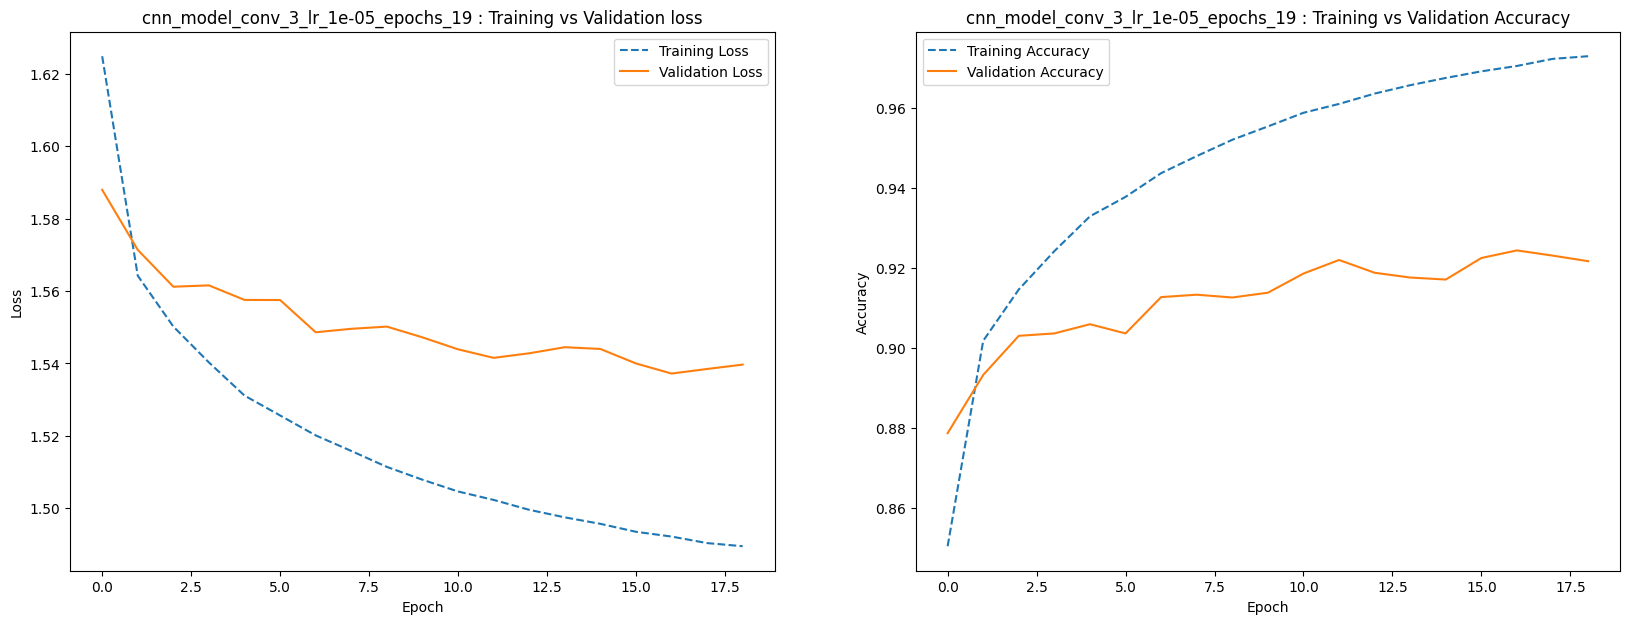


Model Evaluation Summary:


<Figure size 640x480 with 0 Axes>

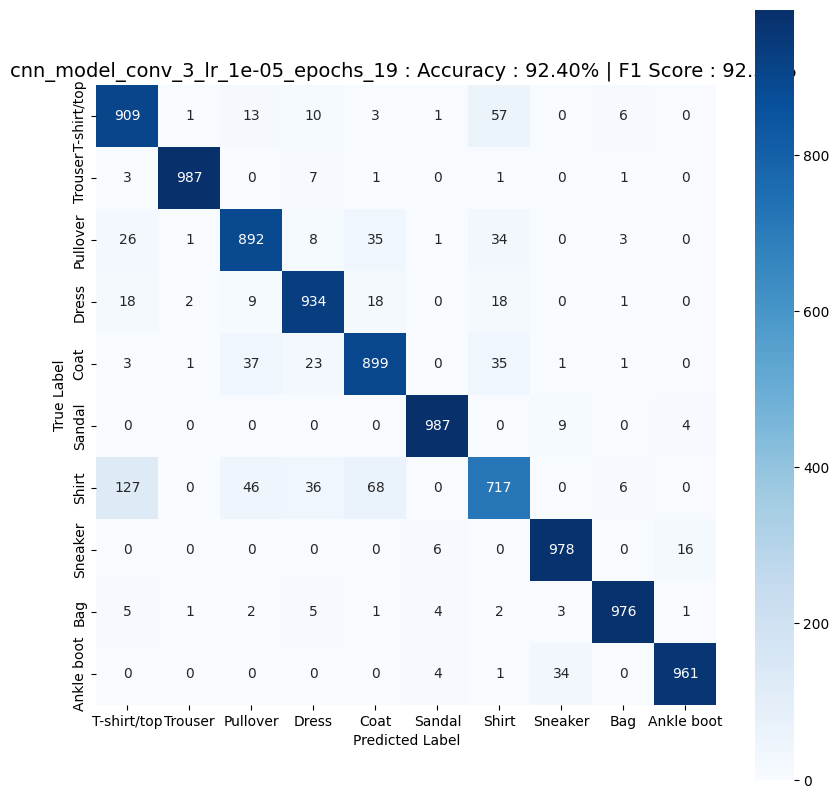

[I 2023-04-23 10:15:51,118] Trial 20 finished with value: 0.924 and parameters: {'conv_layer': 3, 'lr': 1.0046125828694132e-05, 'num_epochs': 19}. Best is trial 20 with value: 0.924.


Accuracy: 92.400%
F1 Score: 92.326%

Classwise Accuracy Score: 
|   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
|         0.909 |     0.987 |      0.892 |   0.934 |  0.899 |    0.987 |   0.717 |     0.978 | 0.976 |        0.961 |

Confusion Matrix:
| True Label   |   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|:-------------|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
| T-shirt/top  |           909 |         1 |         13 |      10 |      3 |        1 |      57 |         0 |     6 |            0 |
| Trouser      |             3 |       987 |          0 |       7 |      1 |        0 |       1 |         0 |     1 |            0 |
| Pullover     |            26 

<Figure size 640x480 with 0 Axes>

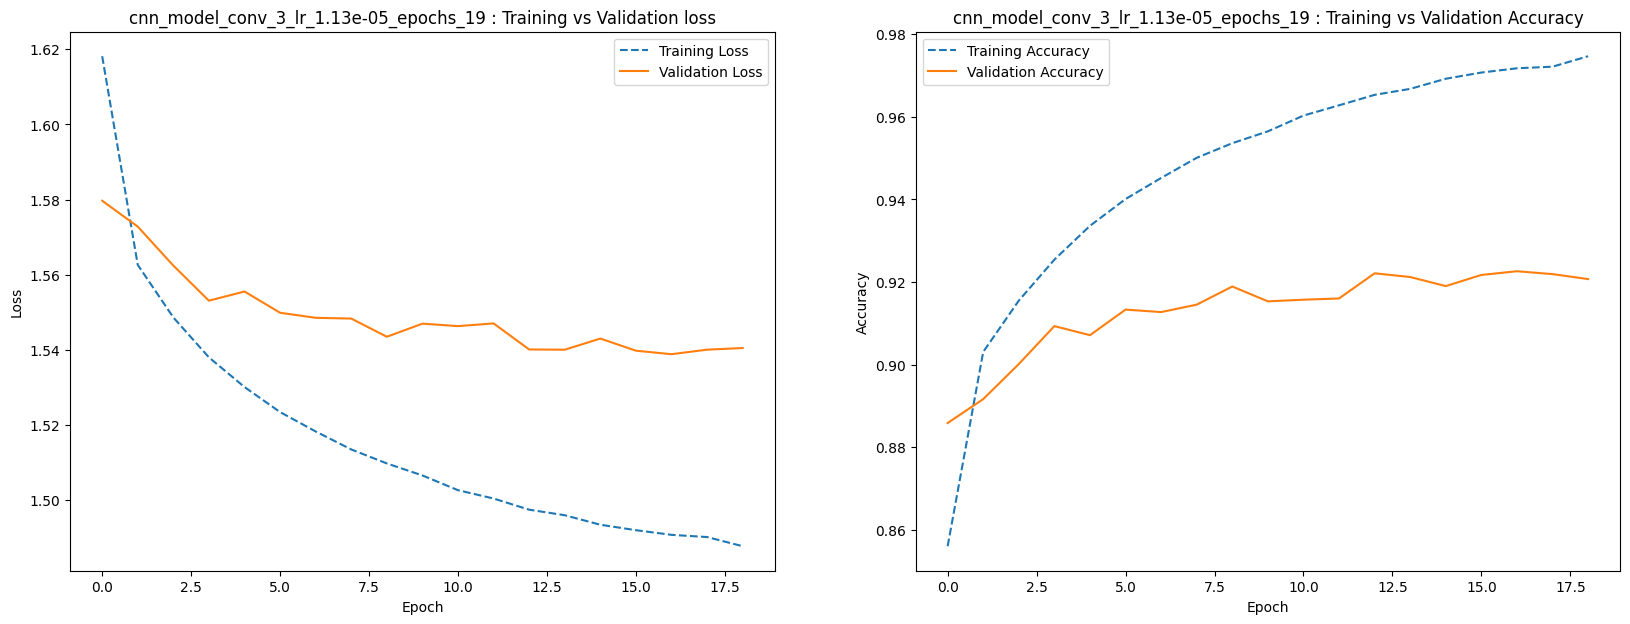


Model Evaluation Summary:


<Figure size 640x480 with 0 Axes>

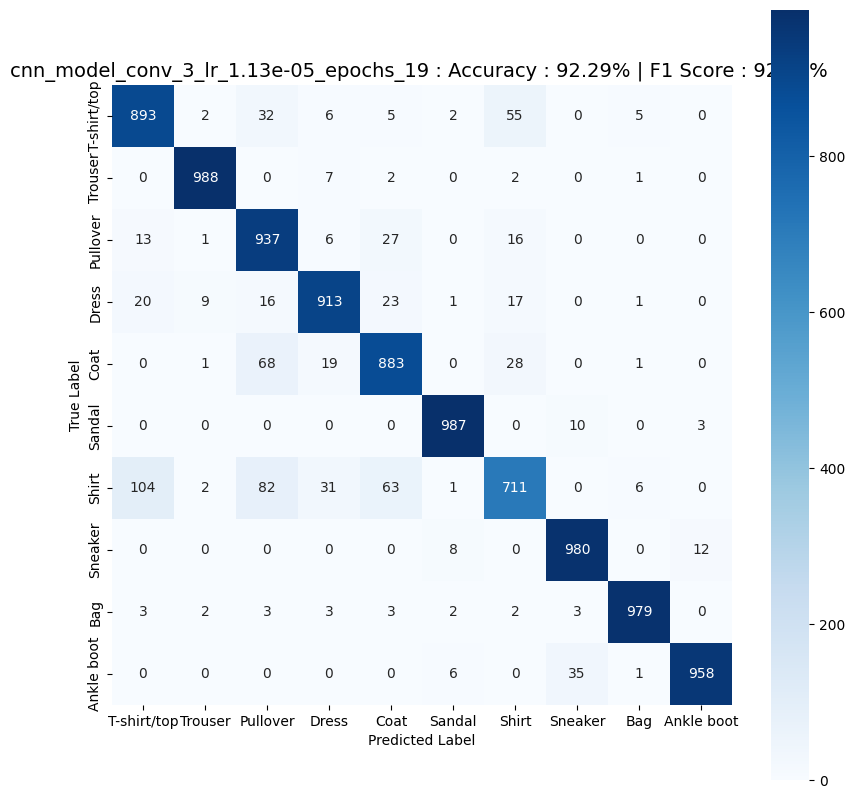

[I 2023-04-23 10:41:16,533] Trial 21 finished with value: 0.9229 and parameters: {'conv_layer': 3, 'lr': 1.1283636192819386e-05, 'num_epochs': 19}. Best is trial 20 with value: 0.924.


Accuracy: 92.290%
F1 Score: 92.205%

Classwise Accuracy Score: 
|   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
|         0.893 |     0.988 |      0.937 |   0.913 |  0.883 |    0.987 |   0.711 |      0.98 | 0.979 |        0.958 |

Confusion Matrix:
| True Label   |   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|:-------------|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
| T-shirt/top  |           893 |         2 |         32 |       6 |      5 |        2 |      55 |         0 |     5 |            0 |
| Trouser      |             0 |       988 |          0 |       7 |      2 |        0 |       2 |         0 |     1 |            0 |
| Pullover     |            13 

<Figure size 640x480 with 0 Axes>

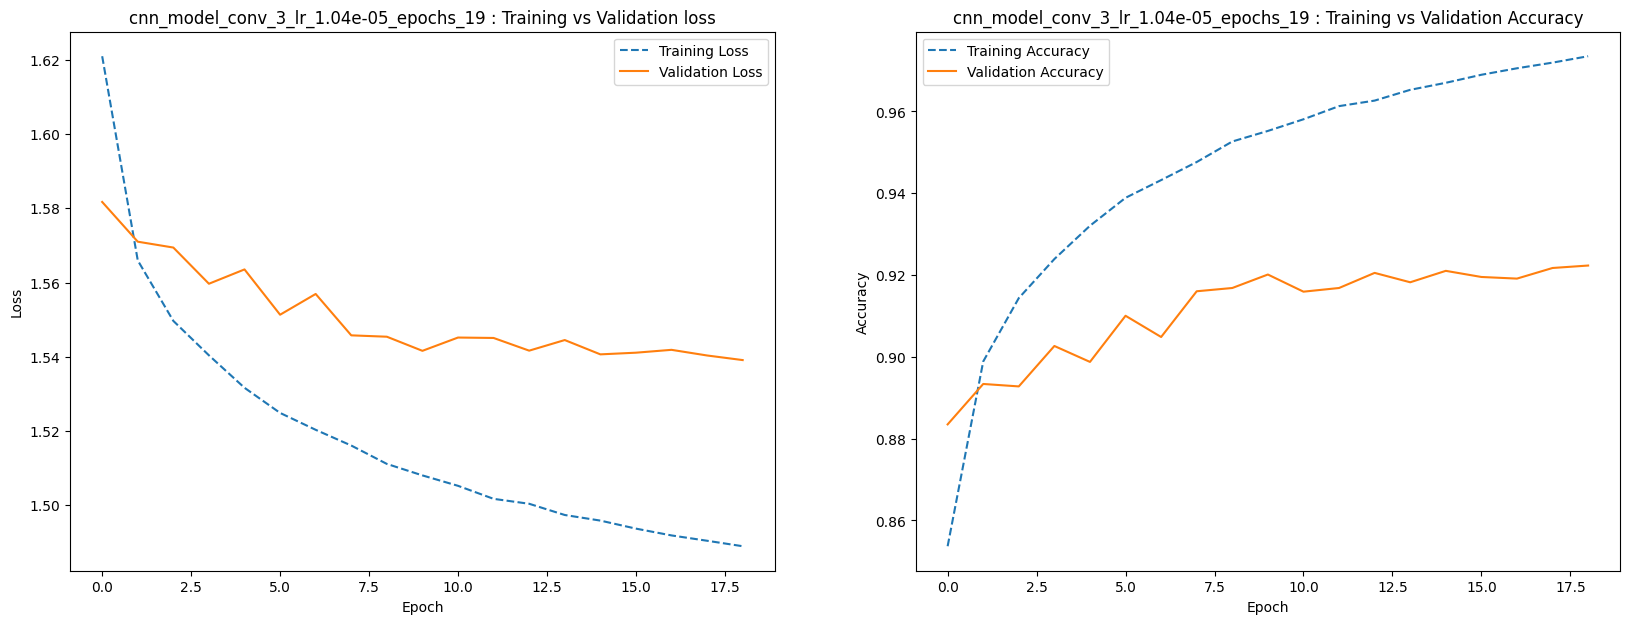


Model Evaluation Summary:


<Figure size 640x480 with 0 Axes>

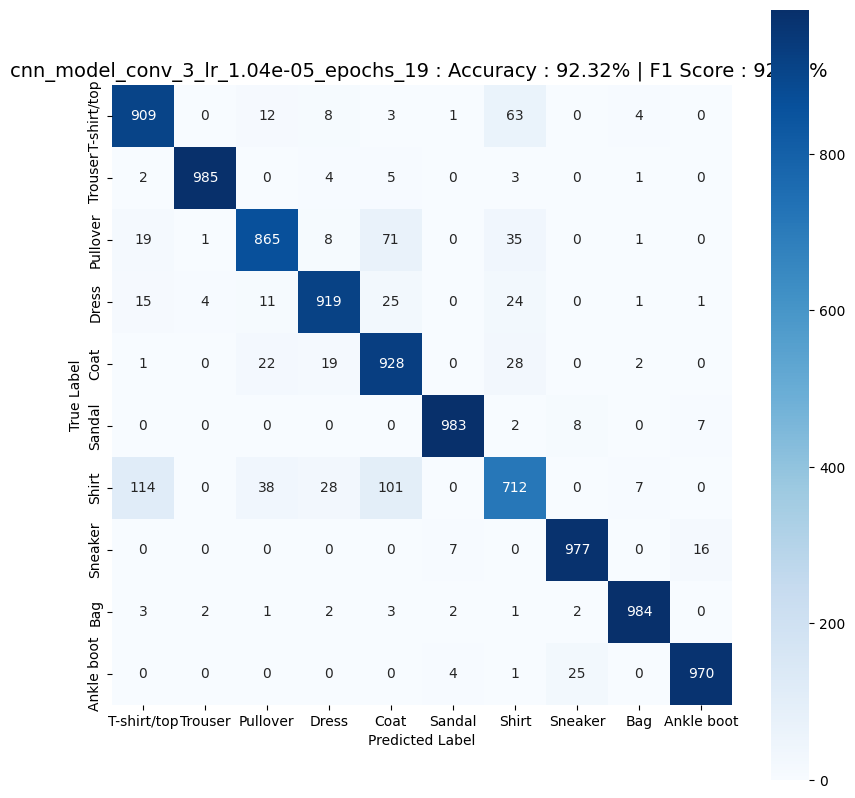

[I 2023-04-23 11:06:52,714] Trial 22 finished with value: 0.9232 and parameters: {'conv_layer': 3, 'lr': 1.0440737427601322e-05, 'num_epochs': 19}. Best is trial 20 with value: 0.924.


Accuracy: 92.320%
F1 Score: 92.258%

Classwise Accuracy Score: 
|   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
|         0.909 |     0.985 |      0.865 |   0.919 |  0.928 |    0.983 |   0.712 |     0.977 | 0.984 |         0.97 |

Confusion Matrix:
| True Label   |   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|:-------------|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
| T-shirt/top  |           909 |         0 |         12 |       8 |      3 |        1 |      63 |         0 |     4 |            0 |
| Trouser      |             2 |       985 |          0 |       4 |      5 |        0 |       3 |         0 |     1 |            0 |
| Pullover     |            19 

[I 2023-04-23 11:30:57,698] Trial 23 pruned. 


Model ====> cnn_model_conv_3_lr_1.05e-05_epochs_19
Epoch: 1 (1m 20s) 	Training Loss: 1.619, 	Test Loss: 1.585,  	Training acc: 0.85, 	Test acc: 0.88, 
Epoch: 2 (1m 20s) 	Training Loss: 1.565, 	Test Loss: 1.578,  	Training acc: 0.90, 	Test acc: 0.89, 
Epoch: 3 (1m 20s) 	Training Loss: 1.551, 	Test Loss: 1.569,  	Training acc: 0.91, 	Test acc: 0.90, 
Epoch: 4 (1m 20s) 	Training Loss: 1.539, 	Test Loss: 1.556,  	Training acc: 0.92, 	Test acc: 0.91, 
Epoch: 5 (1m 19s) 	Training Loss: 1.532, 	Test Loss: 1.554,  	Training acc: 0.93, 	Test acc: 0.91, 
Epoch: 6 (1m 20s) 	Training Loss: 1.525, 	Test Loss: 1.549,  	Training acc: 0.94, 	Test acc: 0.91, 
Epoch: 7 (1m 19s) 	Training Loss: 1.520, 	Test Loss: 1.548,  	Training acc: 0.94, 	Test acc: 0.91, 
Epoch: 8 (1m 20s) 	Training Loss: 1.516, 	Test Loss: 1.551,  	Training acc: 0.95, 	Test acc: 0.91, 
Epoch: 9 (1m 19s) 	Training Loss: 1.511, 	Test Loss: 1.546,  	Training acc: 0.95, 	Test acc: 0.92, 
Epoch: 10 (1m 20s) 	Training Loss: 1.508, 	Test L

<Figure size 640x480 with 0 Axes>

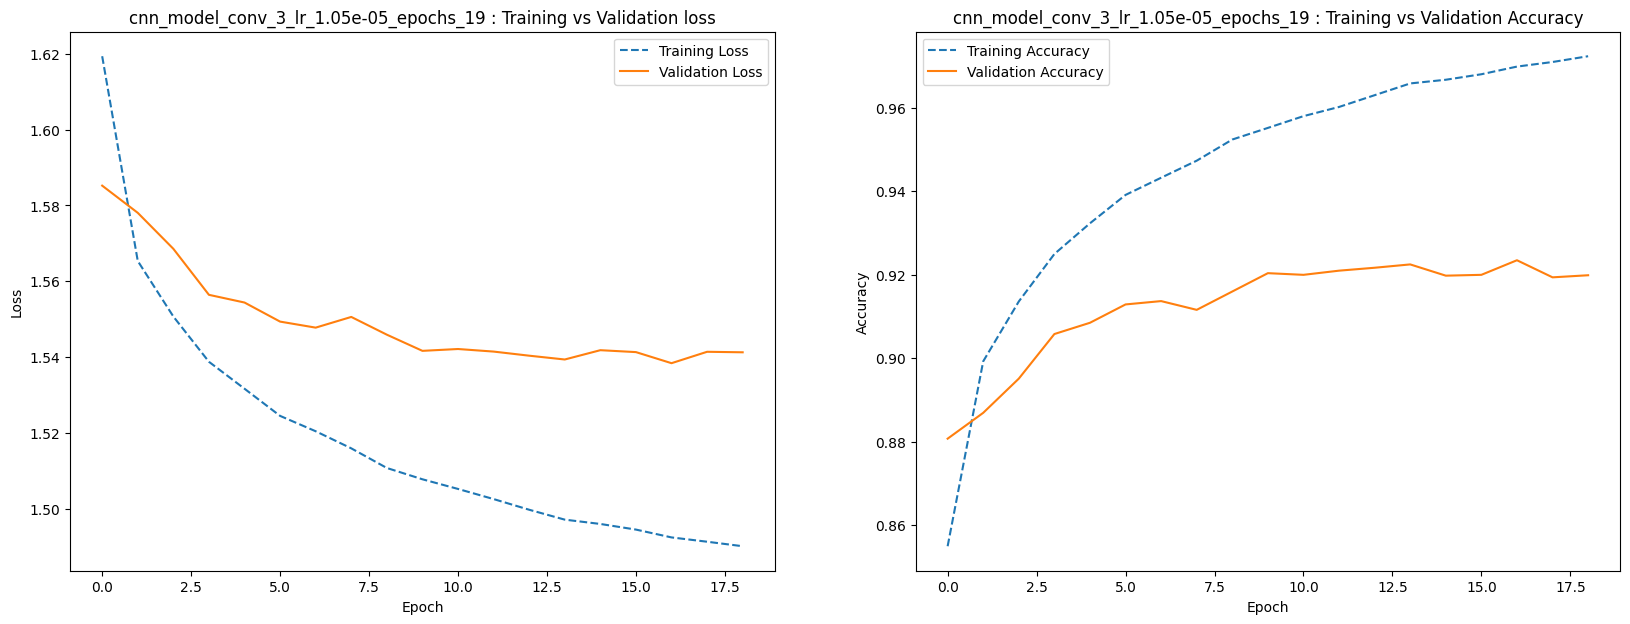


Model Evaluation Summary:


<Figure size 640x480 with 0 Axes>

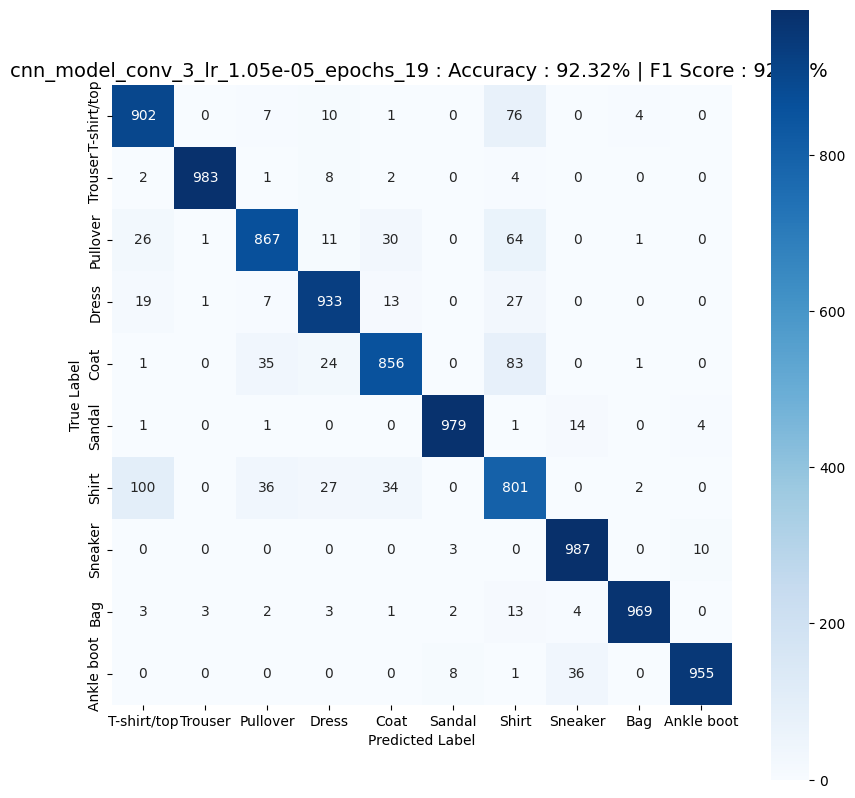

[I 2023-04-23 11:56:23,195] Trial 24 finished with value: 0.9232 and parameters: {'conv_layer': 3, 'lr': 1.0537262440874892e-05, 'num_epochs': 19}. Best is trial 20 with value: 0.924.


Accuracy: 92.320%
F1 Score: 92.375%

Classwise Accuracy Score: 
|   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
|         0.902 |     0.983 |      0.867 |   0.933 |  0.856 |    0.979 |   0.801 |     0.987 | 0.969 |        0.955 |

Confusion Matrix:
| True Label   |   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|:-------------|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
| T-shirt/top  |           902 |         0 |          7 |      10 |      1 |        0 |      76 |         0 |     4 |            0 |
| Trouser      |             2 |       983 |          1 |       8 |      2 |        0 |       4 |         0 |     0 |            0 |
| Pullover     |            26 

[I 2023-04-23 11:59:04,308] Trial 25 pruned. 


Model ====> cnn_model_conv_3_lr_2.21e-05_epochs_16
Epoch: 1 (1m 19s) 	Training Loss: 1.611, 	Test Loss: 1.577,  	Training acc: 0.86, 	Test acc: 0.89, 
Epoch: 2 (1m 20s) 	Training Loss: 1.562, 	Test Loss: 1.566,  	Training acc: 0.90, 	Test acc: 0.90, 
Epoch: 3 (1m 19s) 	Training Loss: 1.548, 	Test Loss: 1.559,  	Training acc: 0.91, 	Test acc: 0.90, 
Epoch: 4 (1m 20s) 	Training Loss: 1.539, 	Test Loss: 1.554,  	Training acc: 0.92, 	Test acc: 0.91, 
Epoch: 5 (1m 20s) 	Training Loss: 1.532, 	Test Loss: 1.553,  	Training acc: 0.93, 	Test acc: 0.91, 
Epoch: 6 (1m 19s) 	Training Loss: 1.527, 	Test Loss: 1.549,  	Training acc: 0.93, 	Test acc: 0.91, 
Epoch: 7 (1m 19s) 	Training Loss: 1.522, 	Test Loss: 1.551,  	Training acc: 0.94, 	Test acc: 0.91, 
Epoch: 8 (1m 20s) 	Training Loss: 1.517, 	Test Loss: 1.547,  	Training acc: 0.94, 	Test acc: 0.91, 
Epoch: 9 (1m 19s) 	Training Loss: 1.514, 	Test Loss: 1.542,  	Training acc: 0.95, 	Test acc: 0.92, 
Epoch: 10 (1m 19s) 	Training Loss: 1.512, 	Test L

<Figure size 640x480 with 0 Axes>

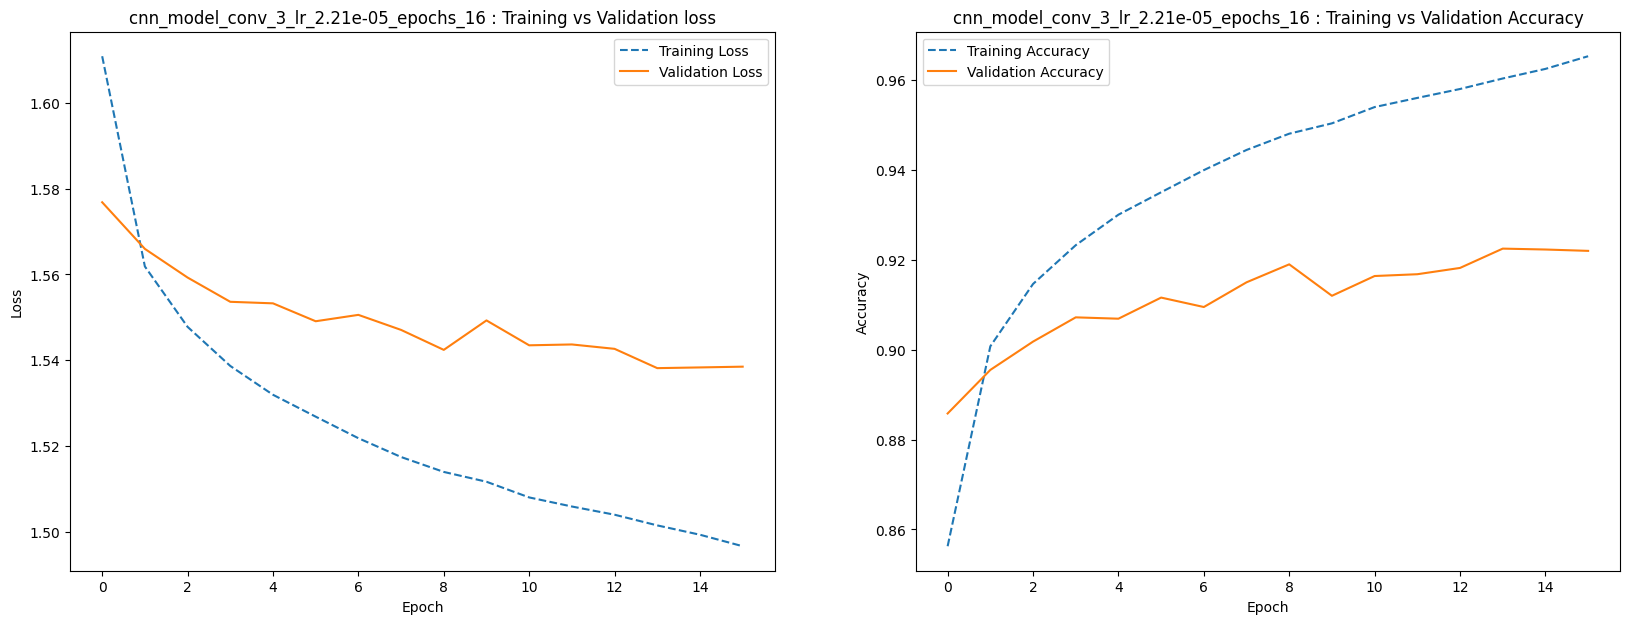


Model Evaluation Summary:


<Figure size 640x480 with 0 Axes>

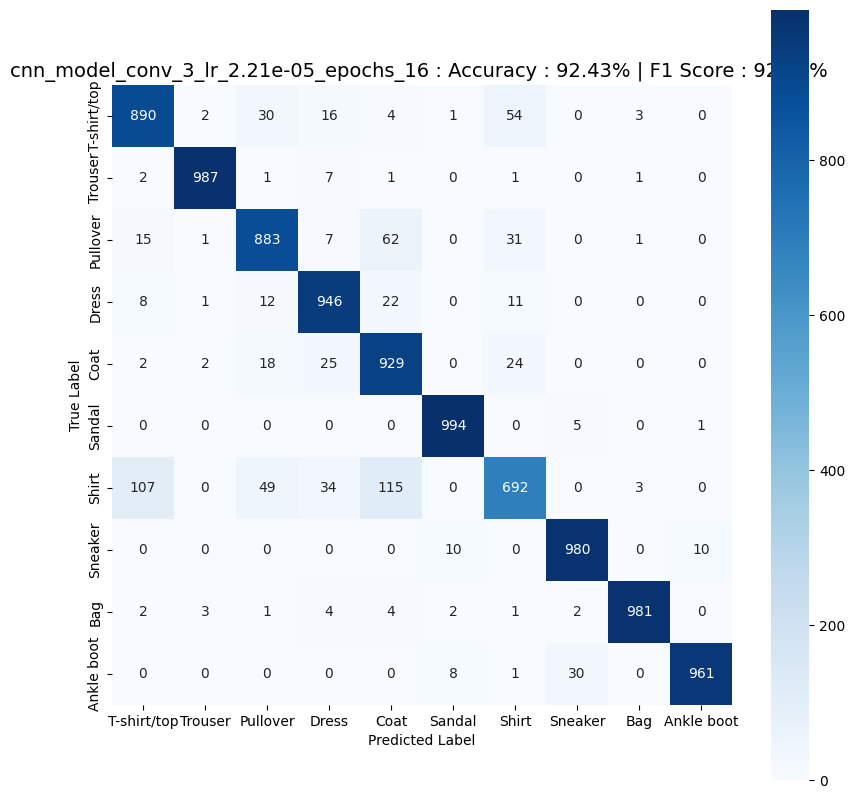

[I 2023-04-23 12:20:29,360] Trial 26 finished with value: 0.9243 and parameters: {'conv_layer': 3, 'lr': 2.2116119968416633e-05, 'num_epochs': 16}. Best is trial 26 with value: 0.9243.


Accuracy: 92.430%
F1 Score: 92.325%

Classwise Accuracy Score: 
|   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
|          0.89 |     0.987 |      0.883 |   0.946 |  0.929 |    0.994 |   0.692 |      0.98 | 0.981 |        0.961 |

Confusion Matrix:
| True Label   |   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|:-------------|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
| T-shirt/top  |           890 |         2 |         30 |      16 |      4 |        1 |      54 |         0 |     3 |            0 |
| Trouser      |             2 |       987 |          1 |       7 |      1 |        0 |       1 |         0 |     1 |            0 |
| Pullover     |            15 

[I 2023-04-23 12:21:50,929] Trial 27 pruned. 


Model ====> cnn_model_conv_3_lr_3.95e-05_epochs_15
Epoch: 1 (1m 21s) 	Training Loss: 1.617, 	Test Loss: 1.595,  	Training acc: 0.85, 	Test acc: 0.87, 
Epoch: 2 (1m 21s) 	Training Loss: 1.569, 	Test Loss: 1.571,  	Training acc: 0.89, 	Test acc: 0.89, 
Epoch: 3 (1m 20s) 	Training Loss: 1.556, 	Test Loss: 1.563,  	Training acc: 0.91, 	Test acc: 0.90, 
Epoch: 4 (1m 20s) 	Training Loss: 1.548, 	Test Loss: 1.565,  	Training acc: 0.91, 	Test acc: 0.89, 
Epoch: 5 (1m 20s) 	Training Loss: 1.542, 	Test Loss: 1.557,  	Training acc: 0.92, 	Test acc: 0.90, 
Epoch: 6 (1m 20s) 	Training Loss: 1.536, 	Test Loss: 1.557,  	Training acc: 0.93, 	Test acc: 0.90, 
Epoch: 7 (1m 20s) 	Training Loss: 1.533, 	Test Loss: 1.552,  	Training acc: 0.93, 	Test acc: 0.91, 
Epoch: 8 (1m 20s) 	Training Loss: 1.529, 	Test Loss: 1.551,  	Training acc: 0.93, 	Test acc: 0.91, 
Epoch: 9 (1m 20s) 	Training Loss: 1.525, 	Test Loss: 1.545,  	Training acc: 0.94, 	Test acc: 0.92, 
Epoch: 10 (1m 20s) 	Training Loss: 1.523, 	Test L

<Figure size 640x480 with 0 Axes>

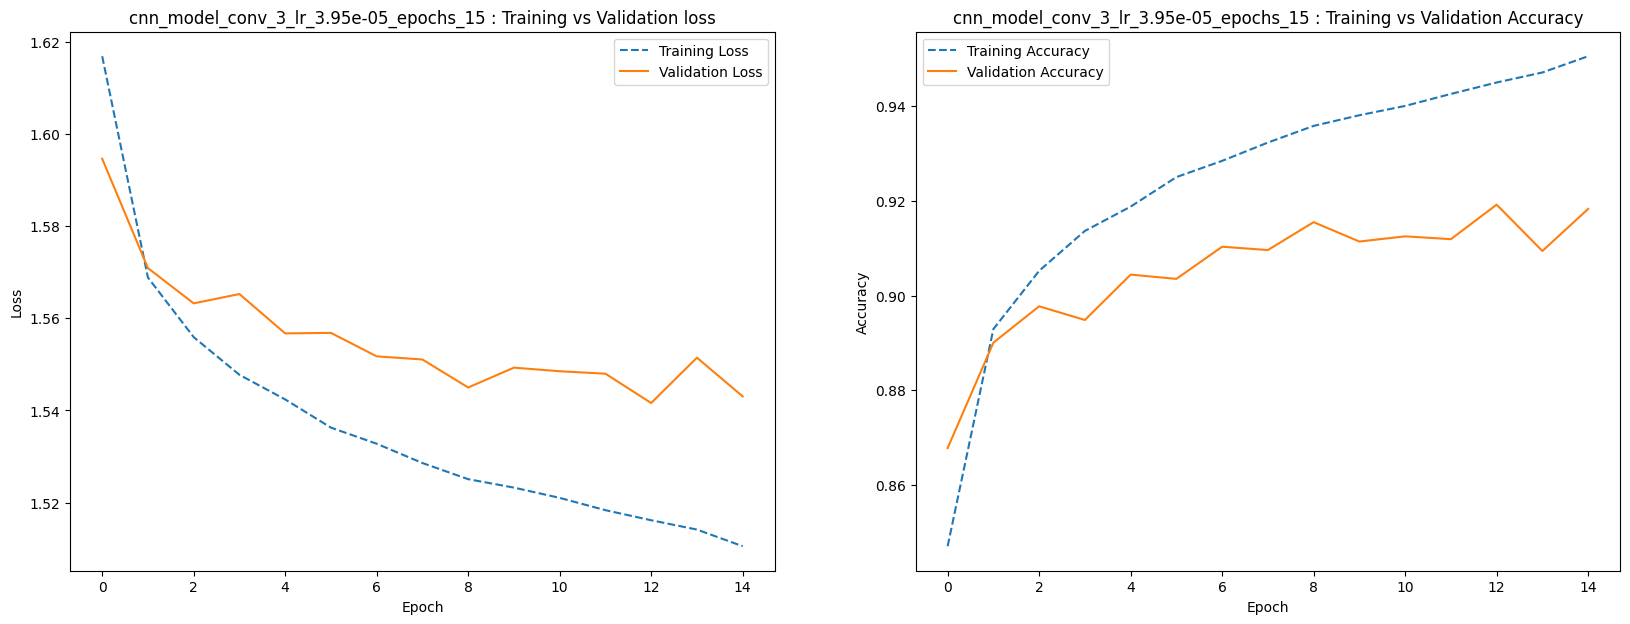


Model Evaluation Summary:


<Figure size 640x480 with 0 Axes>

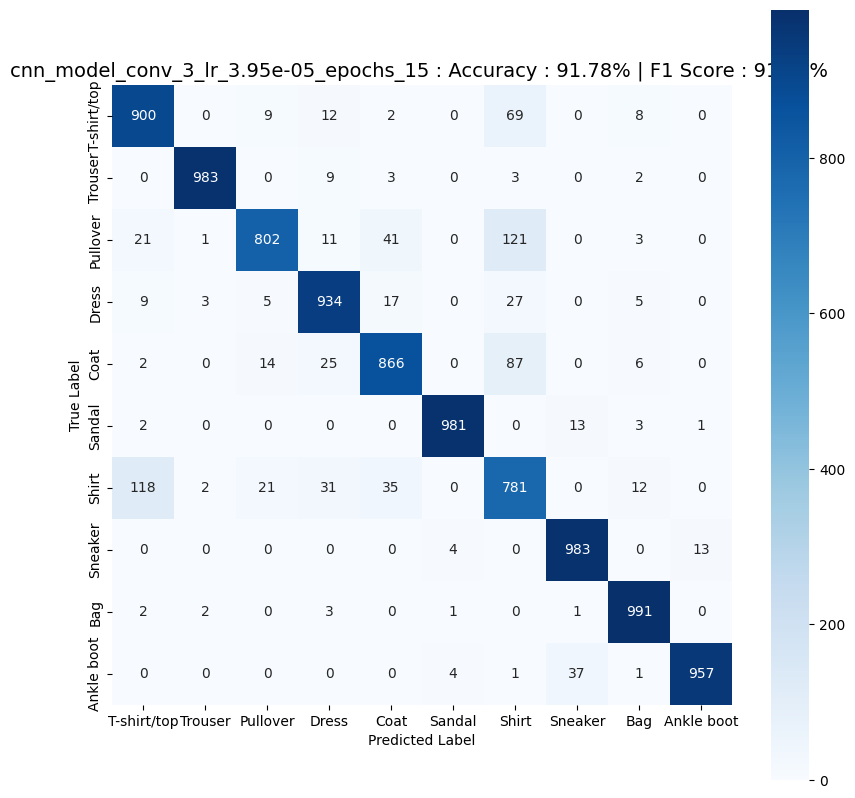

[I 2023-04-23 12:42:03,191] Trial 28 finished with value: 0.9178 and parameters: {'conv_layer': 3, 'lr': 3.9466184098432236e-05, 'num_epochs': 15}. Best is trial 26 with value: 0.9243.


Accuracy: 91.780%
F1 Score: 91.819%

Classwise Accuracy Score: 
|   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
|           0.9 |     0.983 |      0.802 |   0.934 |  0.866 |    0.981 |   0.781 |     0.983 | 0.991 |        0.957 |

Confusion Matrix:
| True Label   |   T-shirt/top |   Trouser |   Pullover |   Dress |   Coat |   Sandal |   Shirt |   Sneaker |   Bag |   Ankle boot |
|:-------------|--------------:|----------:|-----------:|--------:|-------:|---------:|--------:|----------:|------:|-------------:|
| T-shirt/top  |           900 |         0 |          9 |      12 |      2 |        0 |      69 |         0 |     8 |            0 |
| Trouser      |             0 |       983 |          0 |       9 |      3 |        0 |       3 |         0 |     2 |            0 |
| Pullover     |            21 

[I 2023-04-23 12:43:23,492] Trial 29 pruned. 


Model ====> cnn_model_conv_3_lr_2.11e-05_epochs_19


In [ ]:
import optuna
from optuna.trial import TrialState

study = optuna.create_study(direction="maximize")
study.optimize(train_custom_cnn_model, n_trials=100, timeout=60000)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(
    deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
